### Non-Stationary Transformer Approach to model underlying coffee pod volume

Rationale:
1. Ability to capture long term dependencies: Traditional Models (e.g., ARIMA, linear regression) often struggle with long-range dependencies or nonlinear patterns over time, which can be crucial for forecasting sales volume that depends on seasonality, promotions, trends, and other external factors. Transformers, on the other hand, excel at learning long-range dependencies through the self-attention mechanism. This allows them to recognize the relationships between distant time steps in the sequence, which could be especially important for capturing trends or seasonal effects that manifest over longer periods.
2. Process the entire sequence in parallel, making them highly scalable and faster to train, especially when dealing with large amounts of data.
3. The self-attention mechanism in transformers allows the model to "attend" to the most relevant parts of the input sequence when making predictions. This means the model doesn’t just rely on a fixed window of past data, but can focus on the most important past time steps dynamically.
4. Seasonality in sales data (e.g., peaks during holidays, or changes due to weather patterns) can be tricky to model. Transformers are flexible in handling complex, multi-seasonal patterns by learning dependencies across different time scales.
This makes transformers well-suited for capturing nonlinear seasonality, such as weekly or monthly patterns, and trends, as they are able to model interactions between multiple time scales effectively.
5. Transformers are data-driven and do not make strong assumptions about stationarity. Through their flexible attention mechanisms and position encodings, they can capture both trends and seasonality that evolve over time without requiring explicit preprocessing (such as differencing or trend removal). This makes transformers particularly well-suited for forecasting tasks where the data is non-stationary, such as modeling the sales volume of coffee pods that may change over time due to shifting market conditions or consumer behavior.

## Company Pod Sales Modelling
### Fully functional transformer (normal)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Configuration
class Configs:
    def __init__(self):
        self.seq_len = 24  # Historical data length (24 months)
        self.pred_len = 12  # Prediction length (12 months)
        self.d_model = 64  # Embedding dimension
        self.nhead = 4  # Number of attention heads
        self.num_encoder_layers = 2
        self.num_decoder_layers = 2
        self.dropout = 0.1
        self.batch_size = 36
        self.lr = 0.001
        self.num_epochs = 500

configs = Configs()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NonStationaryTransformer(nn.Module): ### this is actually a normal transformer
    def __init__(self, configs):
        super(NonStationaryTransformer, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.d_model = configs.d_model
        self.nhead = configs.nhead
        self.num_encoder_layers = configs.num_encoder_layers
        self.num_decoder_layers = configs.num_decoder_layers
        self.dropout = configs.dropout

        # Embedding layers
        self.encoder_embedding = nn.Linear(1, self.d_model)
        self.decoder_embedding = nn.Linear(1, self.d_model)

        # Transformer
        self.transformer = nn.Transformer(
            d_model=self.d_model,
            nhead=self.nhead,
            num_encoder_layers=self.num_encoder_layers,
            num_decoder_layers=self.num_decoder_layers,
            dropout=self.dropout,
            batch_first=True
        )

        # Output layer
        self.fc_out = nn.Linear(self.d_model, 1)

        # Trend and seasonal components (optional)
        self.trend_layer = nn.Linear(self.seq_len, self.pred_len)
        self.seasonal_layer = nn.Linear(self.seq_len, self.pred_len)

    def forward(self, encoder_input, decoder_input):
        # Embed encoder and decoder inputs
        encoder_embedded = self.encoder_embedding(encoder_input)
        decoder_embedded = self.decoder_embedding(decoder_input)

        # Pass through Transformer
        transformer_output = self.transformer(encoder_embedded, decoder_embedded)

        # Output prediction
        output = self.fc_out(transformer_output)

        # Add trend and seasonal components (if needed)
        trend = self.trend_layer(encoder_input.squeeze(-1)).unsqueeze(-1)
        seasonal = self.seasonal_layer(encoder_input.squeeze(-1)).unsqueeze(-1)
        output = output + trend + seasonal

        return output

class RollingWindowDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, region):
        self.df = df[df['Region'] == region].reset_index(drop=True)
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.data_len = len(self.df)
        self.start_offset = (self.data_len - self.pred_len - self.seq_len) % self.pred_len

    def __len__(self):
        if self.data_len >= self.seq_len + self.pred_len + self.start_offset:
            return (self.data_len - self.seq_len - self.pred_len - self.start_offset) // self.pred_len + 1
        else:
            return 0

    def __getitem__(self, idx):
        start_idx = idx * self.pred_len + self.start_offset
        end_idx = start_idx + self.seq_len + self.pred_len

        encoder_input = self.df['Pods_Units'].iloc[start_idx : start_idx + self.seq_len].values
        decoder_input = self.df['Pods_Units'].iloc[start_idx + self.seq_len : end_idx].values
        target = self.df['Pods_Units'].iloc[start_idx + self.seq_len : end_idx].values
        #dates = self.df['Date'].iloc[start_idx + self.seq_len : end_idx].values

        encoder_input = torch.tensor(encoder_input, dtype=torch.float32).unsqueeze(-1)
        decoder_input = torch.tensor(decoder_input, dtype=torch.float32).unsqueeze(-1)
        target = torch.tensor(target, dtype=torch.float32)

        return encoder_input, decoder_input, target
        #return encoder_input, decoder_input, target, dates

def train_test_split(df, configs):
    region_dataloaders = {}
    regions = df['Region'].unique()

    for region in regions:
        region_df = df[df['Region'] == region].reset_index(drop=True)
        data_len = len(region_df)

        # Last 12 months for testing
        test_len = configs.pred_len
        train_len = data_len - test_len

        # Create training dataset
        train_dataset = RollingWindowDataset(region_df.iloc[:train_len], configs.seq_len, configs.pred_len, region)
        train_loader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=False)

        # Create test dataset
        test_data = region_df.iloc[train_len - configs.seq_len:] # to include seq_len months before test set
        test_encoder_input = test_data['Pods_Units'].iloc[:configs.seq_len].values # last seq months of training data
        test_decoder_input = test_data['Pods_Units'].iloc[configs.seq_len:].values # test set data
        test_target = test_data['Pods_Units'].iloc[configs.seq_len:].values # test set data
        #test_dates = test_data['Date'].iloc[configs.seq_len:].values

        # Convert test data to tensors
        test_encoder_input = torch.tensor(test_encoder_input, dtype=torch.float32).unsqueeze(-1)
        test_decoder_input = torch.tensor(test_decoder_input, dtype=torch.float32).unsqueeze(-1)
        test_target = torch.tensor(test_target, dtype=torch.float32)

        # Create test dataset
        test_batch = [(test_encoder_input, test_decoder_input, test_target)]
        #test_dataset = torch.utils.data.TensorDataset(test_encoder_input, test_decoder_input, test_target)
        test_loader = DataLoader(test_batch, batch_size=1, shuffle=False)

        region_dataloaders[region] = {'train': train_loader, 'test': test_loader}

    return region_dataloaders

def train(region_dataloaders, configs):
    region_models = {}

    for region, dataloaders in region_dataloaders.items():
        model = NonStationaryTransformer(configs).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=configs.lr)

        train_loader = dataloaders['train']

        for epoch in range(configs.num_epochs):
            model.train()
            train_loss = 0.0

            for encoder_input, decoder_input, target in train_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                optimizer.zero_grad()
                output = model(encoder_input, decoder_input).squeeze(-1)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            if (epoch + 1) % 100 ==0:
                print(f"Region: {region}, Epoch: {epoch+1}, Loss: {train_loss/len(train_loader)}")

        region_models[region] = model

    return region_models

def evaluate(region_models, region_dataloaders, configs):
    test_results = {}

    for region, model in region_models.items():
        model.eval()
        criterion = nn.MSELoss()
        test_loader = region_dataloaders[region]['test']

        total_loss = 0.0

        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                output = model(encoder_input, decoder_input).squeeze(-1)
                loss = criterion(output, target)
                total_loss += loss.item()

        #print(len(test_loader))
        test_results[region] = total_loss

    return test_results

def predict_combine(region_models, df, configs):
    '''
    Generate predictions for each rolling window using the trained models, calculate residuals,
    and combine into a single DataFrame. Also calculate overall MAPE and final prediction MAPE.
    '''
    combined_results = []
    overall_actuals = []
    overall_predictions = []
    final_pred_actuals = []
    final_pred_predictions = []

    for region, model in region_models.items():
        model.eval()
        region_df = df[df['Region'] == region].copy().reset_index(drop=True)

        predictions = []
        actuals = []
        time_indices = []
        #dates = []

        # Create dataset for the region
        region_dataset = RollingWindowDataset(
            df=region_df,
            seq_len=configs.seq_len,
            pred_len=configs.pred_len,
            region=region
        )
        region_loader = DataLoader(region_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for idx, (encoder_input, decoder_input, target) in enumerate(region_loader):
            #for encoder_input, decoder_input, target in region_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                # Forward pass
                output = model(encoder_input, decoder_input).squeeze(-1)

                # Store predictions, actual values, and time indices
                predictions.extend(output.cpu().numpy().flatten())
                actuals.extend(target.cpu().numpy().flatten())
                #dates.extend(window_dates)

                # Calculate time indices
                start_idx = region_dataset.start_offset + idx * configs.pred_len
                window_indices = region_df.index[start_idx + configs.seq_len : start_idx + configs.pred_len + configs.seq_len]
                time_indices.extend(window_indices.tolist())  # Use start indices for time indices

        # Calculate residuals
        predictions = np.array(predictions)
        actuals = np.array(actuals)
        residuals = actuals - predictions

        # Store overall actuals and predictions for overall MAPE
        overall_actuals.extend(actuals)
        overall_predictions.extend(predictions)

        # Store final prediction actuals and predictions
        final_pred_actuals.append(actuals[-configs.pred_len:])
        final_pred_predictions.append(predictions[-configs.pred_len:])

        # Create DataFrame for region results
        region_results = pd.DataFrame({
            'Region': region,
            'Timestamp_Index': time_indices,
            #'Date': dates,
            'Actual': actuals,
            'Prediction': predictions,
            'Residual': residuals
        })

        # Append region results to combined results
        combined_results.append(region_results)

    # Combine all results into a single DataFrame
    final_results = pd.concat(combined_results, ignore_index=True)

    # Merge with original df to get corresponding dates
    final_results = final_results.merge(df[['Date']].reset_index(), left_on=['Timestamp_Index'], right_on='index', how='left').drop(columns=['index', 'Timestamp_Index'])

    # Overall MAPE across all regions
    overall_mape = np.mean(np.abs((np.array(overall_actuals) - np.array(overall_predictions)) / np.array(overall_actuals))) * 100

    # Final prediction MAPE (for the final round of predictions)
    final_pred_mape = np.mean(np.abs((np.array(final_pred_actuals) - np.array(final_pred_predictions)) / np.array(final_pred_actuals))) * 100

    return final_results, overall_mape, final_pred_mape

# Pre-processing
df = pd.read_excel("/content/KCUP_Brand_Categorized_Volume.xlsx")

# Preprocess data
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Region'] != 'West']
df = df.groupby(['Region', 'Date'], as_index=False)['Pods_Units'].sum()

# Sort data by Region and Date
df = df.sort_values(by=['Region', 'Date']).reset_index(drop=True)
df['Timestamp_Index'] = (df['Date'].dt.year - 2019) * 12 + (df['Date'].dt.month - 1)

# Create dataloaders for rolling window
region_dataloader = train_test_split(df, configs)  # Use the correct function name

# Train models for each region
region_models = train(region_dataloader, configs)

# Test models and get test results
test_results = evaluate(region_models, region_dataloader, configs)  # Use the correct function name

# Generate predictions and calculate MAPE
final_results, overall_mape, final_pred_mape = predict_combine(region_models, df, configs)

print("Overall MAPE:", overall_mape)
print("Final Prediction MAPE:", final_pred_mape)

final_results.head(10)

Region: Alberta, Epoch: 100, Loss: 3341824032768.0
Region: Alberta, Epoch: 200, Loss: 2367165038592.0
Region: Alberta, Epoch: 300, Loss: 1833638821888.0
Region: Alberta, Epoch: 400, Loss: 1509429870592.0
Region: Alberta, Epoch: 500, Loss: 1264709926912.0
Region: Atlantic, Epoch: 100, Loss: 723591102464.0
Region: Atlantic, Epoch: 200, Loss: 604282486784.0
Region: Atlantic, Epoch: 300, Loss: 525334413312.0
Region: Atlantic, Epoch: 400, Loss: 457674784768.0
Region: Atlantic, Epoch: 500, Loss: 401092542464.0
Region: British Columbia, Epoch: 100, Loss: 1219887890432.0
Region: British Columbia, Epoch: 200, Loss: 982445457408.0
Region: British Columbia, Epoch: 300, Loss: 756207517696.0
Region: British Columbia, Epoch: 400, Loss: 562439192576.0
Region: British Columbia, Epoch: 500, Loss: 410473889792.0
Region: Manitoba/Saskatchewan, Epoch: 100, Loss: 860426600448.0
Region: Manitoba/Saskatchewan, Epoch: 200, Loss: 700527411200.0
Region: Manitoba/Saskatchewan, Epoch: 300, Loss: 576859078656.0
Re

Region      Actual  Prediction   Residual       Date
0  Alberta  14070551.0  13394110.0   676441.0 2021-01-01
1  Alberta  15638987.0  15569520.0    69467.0 2021-02-01
2  Alberta  18508944.0  17845626.0   663318.0 2021-03-01
3  Alberta  14942322.0  14398730.0   543592.0 2021-04-01
4  Alberta  15772950.0  15668864.0   104086.0 2021-05-01
5  Alberta  17648356.0  13895526.0  3752830.0 2021-06-01
6  Alberta  12506010.0  12505886.0      124.0 2021-07-01
7  Alberta  12402535.0  10215980.0  2186555.0 2021-08-01
8  Alberta  17891352.0  18559480.0  -668128.0 2021-09-01
9  Alberta  14318364.0  13441984.0   876380.0 2021-10-01

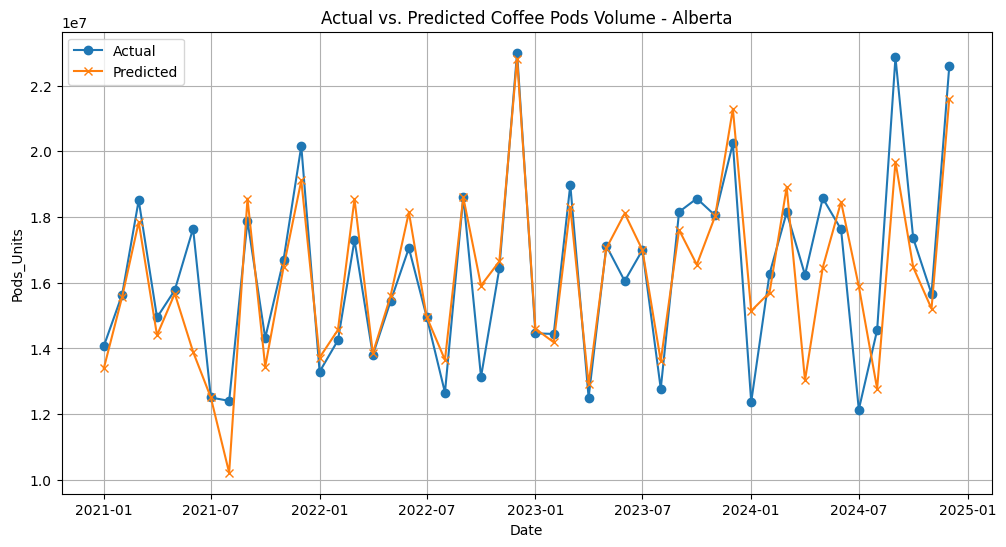

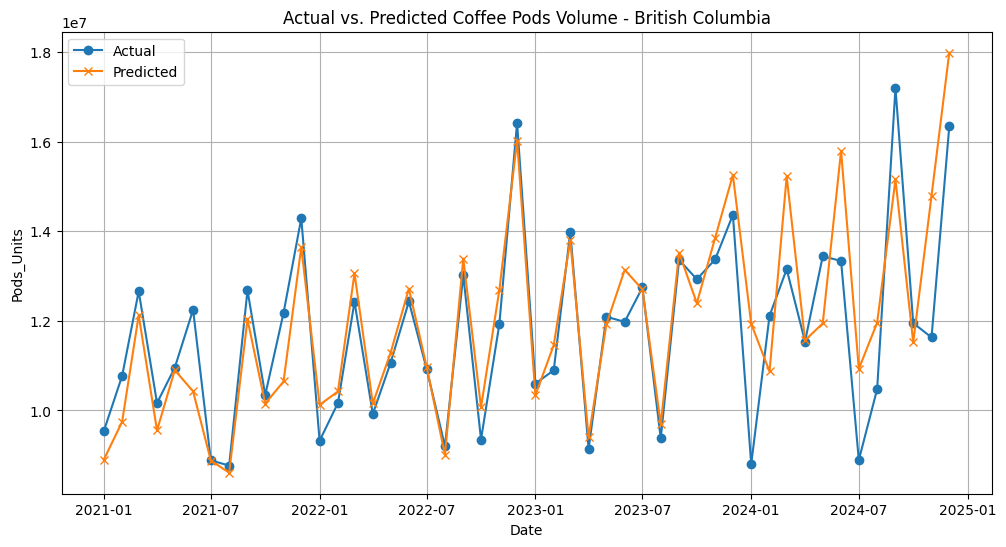

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

# Assuming your RollingWindowDataset, NonStationaryTransformer,
# train_test_split, train, evaluate, and predict_combine functions are defined

def plot_final_results(final_results):
    """
    Plots actual vs. predicted values for each region in the final_results DataFrame.

    Args:
        final_results (pd.DataFrame): DataFrame containing 'Region', 'Timestamp_Index',
                                        'Actual', and 'Prediction' columns.
    """
    regions = final_results['Region'].unique()

    for region in regions:
        region_data = final_results[final_results['Region'] == region]

        plt.figure(figsize=(12, 6))
        plt.plot(region_data['Date'], region_data['Actual'], label='Actual', marker='o')
        plt.plot(region_data['Date'], region_data['Prediction'], label='Predicted', marker='x')

        plt.title(f'Actual vs. Predicted Coffee Pods Volume - {region}')
        plt.xlabel('Date')
        plt.ylabel('Pods_Units')
        plt.legend()
        plt.grid(True)
        plt.show()


plot_final_results(final_results)

Best Parameters: {'n_estimators': 10, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 1.0}



Adjusted Forecast Evaluation
MAPE: 10.19%
RMSE: 14436302.46
R2 Score: 0.620

Prediction Evaluation
MAPE: 10.34%
RMSE: 14367978.09
R2 Score: 0.624


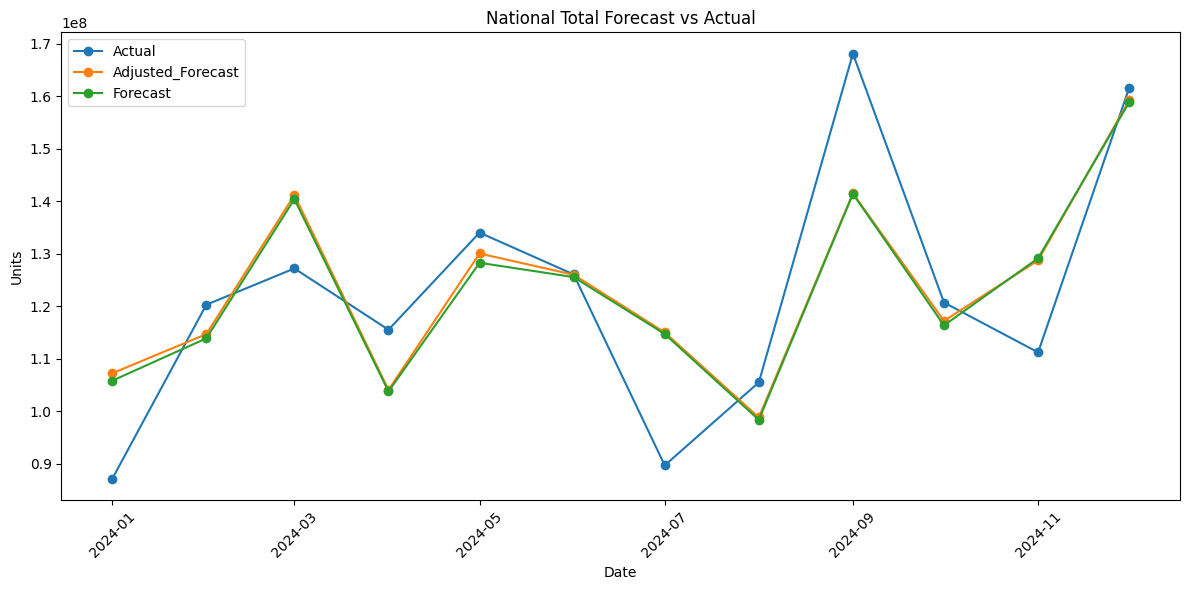

Original feature names count: 74
Original importances count: 74
Adjusted feature names count: 74
Adjusted importances count: 74
Filtered feature names count: 15
Filtered importances count: 15


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
#! pip install shap
import shap
import matplotlib.pyplot as plt

def predict_residuals(residuals, external_data):
    """Use external features to predict the residuals using XGBoost"""

    # Merge residuals and the external data
    combined_data = residuals.merge(external_data, on=['Date', 'Region'], how='left')
    combined_copy = combined_data.copy()
    combined_copy['Month'] = combined_copy['Date'].dt.month

    # Dummify region and month
    combined_copy = pd.get_dummies(combined_copy, columns=['Region', 'Month'])

    unique_dates = sorted(combined_copy['Date'].unique())

    # Split data into train test (last 12 dates as test)
    train_data = combined_copy[~combined_copy['Date'].isin(unique_dates[-12:])]
    test_data = combined_copy[combined_copy['Date'].isin(unique_dates[-12:])]

    # Set up variables
    features = [col for col in combined_copy.columns if col not in ['Date', 'Actual', 'Prediction', 'Residual']]
    y_train, y_test = train_data['Residual'], test_data['Residual']
    X_train, X_test = train_data[features], test_data[features]

    # Define parameter for tuning
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [2, 3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }

    # Function to perform cross-validation manually
    def cross_val(X, y, params):
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []

        for train_index, val_index in kf.split(X):
            X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

            model = xgb.XGBRegressor(eval_metric='mape', **params, random_state=42)
            model.fit(X_train_fold, y_train_fold)

            y_pred = model.predict(X_val_fold)
            score = mean_absolute_percentage_error(y_val_fold, y_pred)
            scores.append(score)

        return np.mean(scores)

    # Manually tune hyperparameters
    best_score = float('inf')
    best_params = None

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                for subsample in param_grid['subsample']:
                    params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'subsample': subsample
                    }

                    score = cross_val(X_train, y_train, params)

                    if score < best_score:
                        best_score = score
                        best_params = params

    print(f"Best Parameters: {best_params}")

    X_train_encoded = X_train.copy()
    X_bool = X_train_encoded.select_dtypes(include=['boolean'])
    X_train_encoded[X_bool.columns] = X_bool.astype(float)

    # Train best model on X_train
    best_xgb = xgb.XGBRegressor(**best_params, eval_metric='mape', random_state=42)
    best_xgb.fit(X_train, y_train)

    # Store feature importance
    importances = best_xgb.feature_importances_

    # Plot SHAP
    explainer = shap.Explainer(best_xgb, X_train_encoded)
    shap_values = explainer(X_train_encoded)
    shap.summary_plot(shap_values, X_train_encoded)

    # Predict residuals
    residual_predictions = best_xgb.predict(X_test)

    # Create residuals_pred DataFrame
    residuals_pred = combined_data[combined_data['Date'].isin(unique_dates[-12:])].copy()
    residuals_pred['Predicted_Residual'] = residual_predictions
    residuals_pred['Adjusted_Forecast'] = residuals_pred['Prediction'] + residuals_pred['Predicted_Residual']

    return residuals_pred, importances, features  # Return importances

def evaluate_predictions(y_true, y_pred, title="Model Evaluation"):
    """Evaluate prediction results"""
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n{title}")
    print(f"MAPE: {mape:.2%}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.3f}")

    return {'mape': mape, 'rmse': rmse, 'r2': r2}

def plot_forecast_vs_actual(forecasts, title=None):
    """Visualize forecast results vs actual values (aggregated across regions)"""

    # Aggregate data by date
    aggregated_data = forecasts.groupby('Date').agg({
        'Actual': 'sum',
        'Prediction': 'sum',
        'Adjusted_Forecast': 'sum'
    }).reset_index()

    title = title or "National Total Forecast vs Actual"

    plt.figure(figsize=(12, 6))
    plt.plot(aggregated_data['Date'], aggregated_data['Actual'], label='Actual', marker='o')
    plt.plot(aggregated_data['Date'], aggregated_data['Adjusted_Forecast'], label='Adjusted_Forecast', marker='o')
    plt.plot(aggregated_data['Date'], aggregated_data['Prediction'], label='Forecast', marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Units')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_importances(importances, feature_names):
    print(f"Original feature names count: {len(feature_names)}")
    print(f"Original importances count: {len(importances)}")

    # Ensure importances and feature_names have the same length
    min_length = min(len(importances), len(feature_names))
    importances = importances[:min_length]
    feature_names = feature_names[:min_length]

    print(f"Adjusted feature names count: {len(feature_names)}")
    print(f"Adjusted importances count: {len(importances)}")

    # Use indices for filtering
    nonzero_indices = np.nonzero(importances)[0]
    filtered_feature_names = [feature_names[i] for i in nonzero_indices]
    filtered_importances = importances[nonzero_indices]

    print(f"Filtered feature names count: {len(filtered_feature_names)}")
    print(f"Filtered importances count: {len(filtered_importances)}")

    if len(filtered_feature_names) != len(filtered_importances):
        print("Error: Mismatch in feature names and importance values after filtering.")
        return

    feature_importance_df = pd.DataFrame({
        'Feature': filtered_feature_names,
        'Importance': filtered_importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 15))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance - XGBoost')
    plt.gca().invert_yaxis()
    plt.show()

# Load data
external_data = pd.read_csv('/content/used_external_features.csv')
external_data['Date'] = pd.to_datetime(external_data['Date'])

# Call function
residuals_pred, importances, features = predict_residuals(final_results, external_data)

# Aggregate data for evaluation
aggregated_data = residuals_pred.groupby('Date').agg({
    'Actual': 'sum',
    'Prediction': 'sum',
    'Adjusted_Forecast': 'sum'
}).reset_index()

# Evaluate predictions
evaluation_results = evaluate_predictions(aggregated_data['Actual'], aggregated_data['Adjusted_Forecast'], title="Adjusted Forecast Evaluation")
evaluation_results_prediction = evaluate_predictions(aggregated_data['Actual'], aggregated_data['Prediction'], title = "Prediction Evaluation")

# Plot forecast vs actual (aggregated)
plot_forecast_vs_actual(residuals_pred)

# Plot feature importances
#feature_names = [col for col in residuals_pred.columns if col not in ['Date', 'Actual', 'Prediction', 'Residual', 'Predicted_Residual', 'Adjusted_Forecast']]
plot_importances(importances, features)

## Transformer with elements of non-stationary handling

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Configuration
class Configs:
    def __init__(self):
        self.seq_len = 24
        self.pred_len = 12
        self.d_model = 64
        self.nhead = 4
        self.num_encoder_layers = 2
        self.num_decoder_layers = 2
        self.dropout = 0.1
        self.batch_size = 36
        self.lr = 0.001
        self.num_epochs = 500

configs = Configs()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NonStationaryTransformer(nn.Module):
    def __init__(self, configs):
        super(NonStationaryTransformer, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.d_model = configs.d_model
        self.nhead = configs.nhead
        self.num_encoder_layers = configs.num_encoder_layers
        self.num_decoder_layers = configs.num_decoder_layers
        self.dropout = configs.dropout

        # Embedding layers
        self.encoder_embedding = nn.Linear(1, self.d_model)
        self.decoder_embedding = nn.Linear(1, self.d_model)

        # Time Embedding
        self.time_embedding = nn.Embedding(configs.seq_len + configs.pred_len, self.d_model)

        # Transformer
        self.transformer = nn.Transformer(
            d_model=self.d_model,
            nhead=self.nhead,
            num_encoder_layers=self.num_encoder_layers,
            num_decoder_layers=self.num_decoder_layers,
            dropout=self.dropout,
            batch_first=True
        )

        # Output layer
        self.fc_out = nn.Linear(self.d_model, 1)

        # Adaptive Normalization
        self.adaptive_norm = nn.LayerNorm(self.d_model)

        # Sophisticated Trend and Seasonal Components
        self.trend_layer = nn.Sequential(
            nn.Linear(self.seq_len, 64),
            nn.ReLU(),
            nn.Linear(64, self.pred_len)
        )
        self.seasonal_layer = nn.Sequential(
            nn.Linear(self.seq_len, 64),
            nn.ReLU(),
            nn.Linear(64, self.pred_len)
        )

    def forward(self, encoder_input, decoder_input):
        encoder_embedded = self.encoder_embedding(encoder_input)
        decoder_embedded = self.decoder_embedding(decoder_input)

        # Create time indices for embedding
        encoder_time_indices = torch.arange(self.seq_len, device=encoder_input.device).unsqueeze(0).repeat(encoder_input.size(0), 1)
        decoder_time_indices = torch.arange(self.seq_len, self.seq_len + self.pred_len, device=decoder_input.device).unsqueeze(0).repeat(decoder_input.size(0), 1)

        # Add time embeddings
        encoder_embedded += self.time_embedding(encoder_time_indices)
        decoder_embedded += self.time_embedding(decoder_time_indices)

        transformer_output = self.transformer(encoder_embedded, decoder_embedded)

        # Adaptive Normalization
        transformer_output = self.adaptive_norm(transformer_output)

        output = self.fc_out(transformer_output)

        # Trend and Seasonal Components
        trend = self.trend_layer(encoder_input.squeeze(-1)).unsqueeze(-1)
        seasonal = self.seasonal_layer(encoder_input.squeeze(-1)).unsqueeze(-1)
        output = output + trend + seasonal

        return output

class RollingWindowDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, region):
        self.df = df[df['Region'] == region].reset_index(drop=True)
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.data_len = len(self.df)
        self.start_offset = (self.data_len - self.pred_len - self.seq_len) % self.pred_len

    def __len__(self):
        if self.data_len >= self.seq_len + self.pred_len + self.start_offset:
            return (self.data_len - self.seq_len - self.pred_len - self.start_offset) // self.pred_len + 1
        else:
            return 0

    def __getitem__(self, idx):
        start_idx = idx * self.pred_len + self.start_offset
        end_idx = start_idx + self.seq_len + self.pred_len

        encoder_input = self.df['Pods_Units'].iloc[start_idx : start_idx + self.seq_len].values
        decoder_input = self.df['Pods_Units'].iloc[start_idx + self.seq_len : end_idx].values
        target = self.df['Pods_Units'].iloc[start_idx + self.seq_len : end_idx].values
        #dates = self.df['Date'].iloc[start_idx + self.seq_len : end_idx].values

        encoder_input = torch.tensor(encoder_input, dtype=torch.float32).unsqueeze(-1)
        decoder_input = torch.tensor(decoder_input, dtype=torch.float32).unsqueeze(-1)
        target = torch.tensor(target, dtype=torch.float32)

        return encoder_input, decoder_input, target
        #return encoder_input, decoder_input, target, dates

def train_test_split(df, configs):
    region_dataloaders = {}
    regions = df['Region'].unique()

    for region in regions:
        region_df = df[df['Region'] == region].reset_index(drop=True)
        data_len = len(region_df)

        # Last 12 months for testing
        test_len = configs.pred_len
        train_len = data_len - test_len

        # Create training dataset
        train_dataset = RollingWindowDataset(region_df.iloc[:train_len], configs.seq_len, configs.pred_len, region)
        train_loader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=False)

        # Create test dataset
        test_data = region_df.iloc[train_len - configs.seq_len:] # to include seq_len months before test set
        test_encoder_input = test_data['Pods_Units'].iloc[:configs.seq_len].values # last seq months of training data
        test_decoder_input = test_data['Pods_Units'].iloc[configs.seq_len:].values # test set data
        test_target = test_data['Pods_Units'].iloc[configs.seq_len:].values # test set data
        #test_dates = test_data['Date'].iloc[configs.seq_len:].values

        # Convert test data to tensors
        test_encoder_input = torch.tensor(test_encoder_input, dtype=torch.float32).unsqueeze(-1)
        test_decoder_input = torch.tensor(test_decoder_input, dtype=torch.float32).unsqueeze(-1)
        test_target = torch.tensor(test_target, dtype=torch.float32)

        # Create test dataset
        test_batch = [(test_encoder_input, test_decoder_input, test_target)]
        #test_dataset = torch.utils.data.TensorDataset(test_encoder_input, test_decoder_input, test_target)
        test_loader = DataLoader(test_batch, batch_size=1, shuffle=False)

        region_dataloaders[region] = {'train': train_loader, 'test': test_loader}

    return region_dataloaders

def train(region_dataloaders, configs):
    region_models = {}

    for region, dataloaders in region_dataloaders.items():
        model = NonStationaryTransformer(configs).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=configs.lr)

        train_loader = dataloaders['train']

        for epoch in range(configs.num_epochs):
            model.train()
            train_loss = 0.0

            for encoder_input, decoder_input, target in train_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                optimizer.zero_grad()
                output = model(encoder_input, decoder_input).squeeze(-1)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            if (epoch + 1) % 100 ==0:
                print(f"Region: {region}, Epoch: {epoch+1}, Loss: {train_loss/len(train_loader)}")

        region_models[region] = model

    return region_models

def evaluate(region_models, region_dataloaders, configs):
    test_results = {}

    for region, model in region_models.items():
        model.eval()
        criterion = nn.MSELoss()
        test_loader = region_dataloaders[region]['test']

        total_loss = 0.0

        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                output = model(encoder_input, decoder_input).squeeze(-1)
                loss = criterion(output, target)
                total_loss += loss.item()

        #print(len(test_loader))
        test_results[region] = total_loss

    return test_results

def predict_combine(region_models, df, configs):
    '''
    Generate predictions for each rolling window using the trained models, calculate residuals,
    and combine into a single DataFrame. Also calculate overall MAPE and final prediction MAPE.
    '''
    combined_results = []
    overall_actuals = []
    overall_predictions = []
    final_pred_actuals = []
    final_pred_predictions = []

    for region, model in region_models.items():
        model.eval()
        region_df = df[df['Region'] == region].copy().reset_index(drop=True)

        predictions = []
        actuals = []
        time_indices = []
        #dates = []

        # Create dataset for the region
        region_dataset = RollingWindowDataset(
            df=region_df,
            seq_len=configs.seq_len,
            pred_len=configs.pred_len,
            region=region
        )
        region_loader = DataLoader(region_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for idx, (encoder_input, decoder_input, target) in enumerate(region_loader):
            #for encoder_input, decoder_input, target in region_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                # Forward pass
                output = model(encoder_input, decoder_input).squeeze(-1)

                # Store predictions, actual values, and time indices
                predictions.extend(output.cpu().numpy().flatten())
                actuals.extend(target.cpu().numpy().flatten())
                #dates.extend(window_dates)

                # Calculate time indices
                start_idx = region_dataset.start_offset + idx * configs.pred_len
                window_indices = region_df.index[start_idx + configs.seq_len : start_idx + configs.pred_len + configs.seq_len]
                time_indices.extend(window_indices.tolist())  # Use start indices for time indices

        # Calculate residuals
        predictions = np.array(predictions)
        actuals = np.array(actuals)
        residuals = actuals - predictions

        # Store overall actuals and predictions for overall MAPE
        overall_actuals.extend(actuals)
        overall_predictions.extend(predictions)

        # Store final prediction actuals and predictions
        final_pred_actuals.append(actuals[-configs.pred_len:])
        final_pred_predictions.append(predictions[-configs.pred_len:])

        # Create DataFrame for region results
        region_results = pd.DataFrame({
            'Region': region,
            'Timestamp_Index': time_indices,
            #'Date': dates,
            'Actual': actuals,
            'Prediction': predictions,
            'Residual': residuals
        })

        # Append region results to combined results
        combined_results.append(region_results)

    # Combine all results into a single DataFrame
    final_results = pd.concat(combined_results, ignore_index=True)

    # Merge with original df to get corresponding dates
    final_results = final_results.merge(df[['Date']].reset_index(), left_on=['Timestamp_Index'], right_on='index', how='left').drop(columns=['index', 'Timestamp_Index'])

    # Overall MAPE across all regions
    overall_mape = np.mean(np.abs((np.array(overall_actuals) - np.array(overall_predictions)) / np.array(overall_actuals))) * 100

    # Final prediction MAPE (for the final round of predictions)
    final_pred_mape = np.mean(np.abs((np.array(final_pred_actuals) - np.array(final_pred_predictions)) / np.array(final_pred_actuals))) * 100

    return final_results, overall_mape, final_pred_mape

# Pre-processing
df = pd.read_excel("/content/KCUP_Brand_Categorized_Volume.xlsx")

# Preprocess data
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Region'] != 'West']
df = df.groupby(['Region', 'Date'], as_index=False)['Pods_Units'].sum()

# Sort data by Region and Date
df = df.sort_values(by=['Region', 'Date']).reset_index(drop=True)
df['Timestamp_Index'] = (df['Date'].dt.year - 2019) * 12 + (df['Date'].dt.month - 1)

# Create dataloaders for rolling window
region_dataloader = train_test_split(df, configs)  # Use the correct function name

# Train models for each region
region_models = train(region_dataloader, configs)

# Test models and get test results
test_results = evaluate(region_models, region_dataloader, configs)  # Use the correct function name

# Generate predictions and calculate MAPE
final_results, overall_mape, final_pred_mape = predict_combine(region_models, df, configs)

print("Overall MAPE:", overall_mape)
print("Final Prediction MAPE:", final_pred_mape)

final_results.head(10)

Region: Alberta, Epoch: 100, Loss: 1628176252928.0
Region: Alberta, Epoch: 200, Loss: 1193031499776.0
Region: Alberta, Epoch: 300, Loss: 828430286848.0
Region: Alberta, Epoch: 400, Loss: 580243685376.0
Region: Alberta, Epoch: 500, Loss: 428917817344.0
Region: Atlantic, Epoch: 100, Loss: 601073713152.0
Region: Atlantic, Epoch: 200, Loss: 447797592064.0
Region: Atlantic, Epoch: 300, Loss: 326046253056.0
Region: Atlantic, Epoch: 400, Loss: 243533283328.0
Region: Atlantic, Epoch: 500, Loss: 189598531584.0
Region: British Columbia, Epoch: 100, Loss: 942217035776.0
Region: British Columbia, Epoch: 200, Loss: 694332555264.0
Region: British Columbia, Epoch: 300, Loss: 491332829184.0
Region: British Columbia, Epoch: 400, Loss: 354328838144.0
Region: British Columbia, Epoch: 500, Loss: 272019832832.0
Region: Manitoba/Saskatchewan, Epoch: 100, Loss: 682561634304.0
Region: Manitoba/Saskatchewan, Epoch: 200, Loss: 515318710272.0
Region: Manitoba/Saskatchewan, Epoch: 300, Loss: 356000268288.0
Region

Region      Actual  Prediction  Residual       Date
0  Alberta  14070551.0  13605526.0  465025.0 2021-01-01
1  Alberta  15638987.0  15464525.0  174462.0 2021-02-01
2  Alberta  18508944.0  17648658.0  860286.0 2021-03-01
3  Alberta  14942322.0  14861774.0   80548.0 2021-04-01
4  Alberta  15772950.0  15504631.0  268319.0 2021-05-01
5  Alberta  17648356.0  17424252.0  224104.0 2021-06-01
6  Alberta  12506010.0  12615012.0 -109002.0 2021-07-01
7  Alberta  12402535.0  12212058.0  190477.0 2021-08-01
8  Alberta  17891352.0  17568672.0  322680.0 2021-09-01
9  Alberta  14318364.0  13933461.0  384903.0 2021-10-01

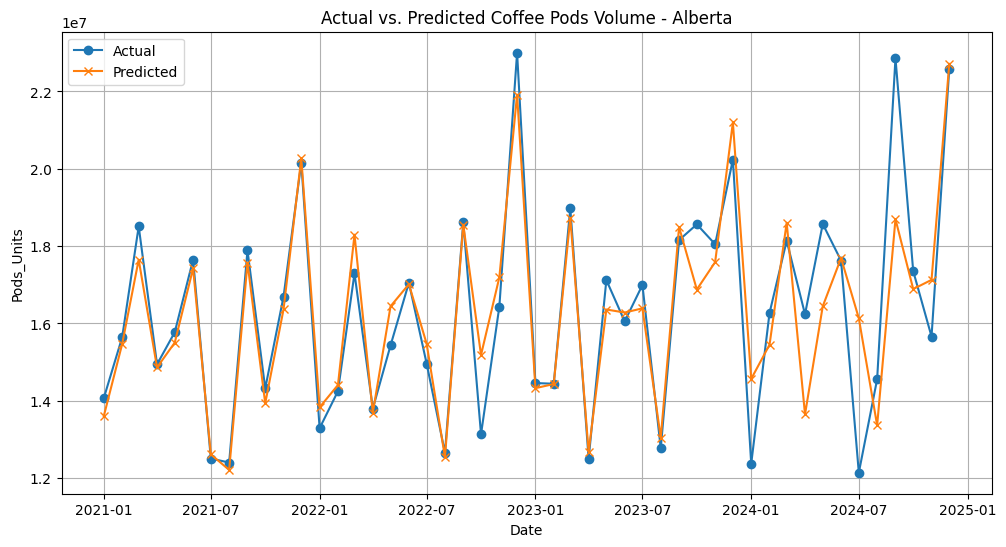

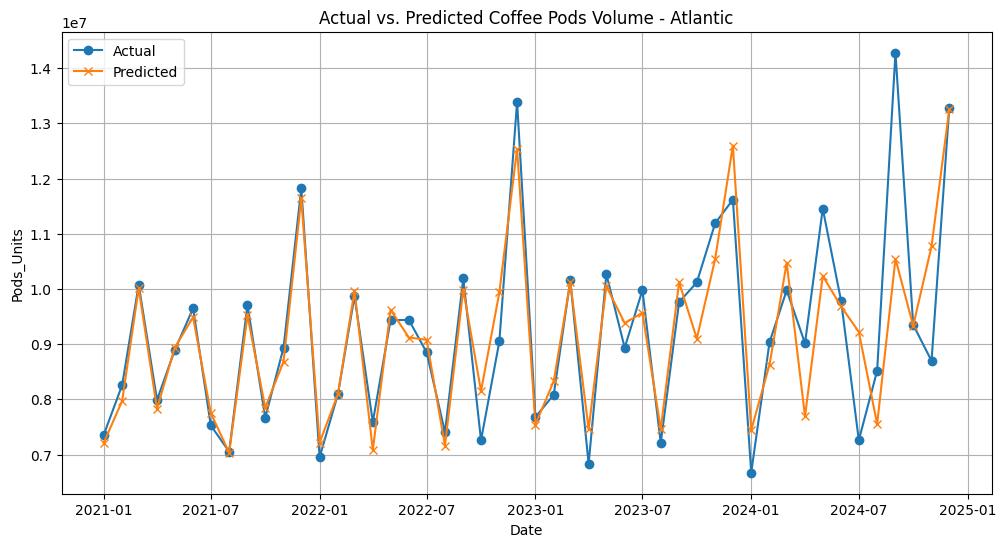

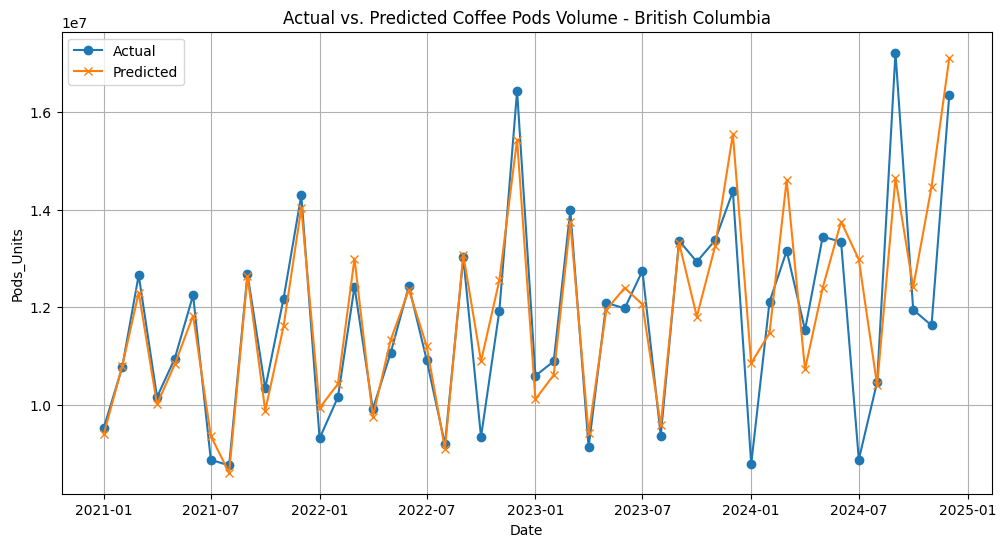

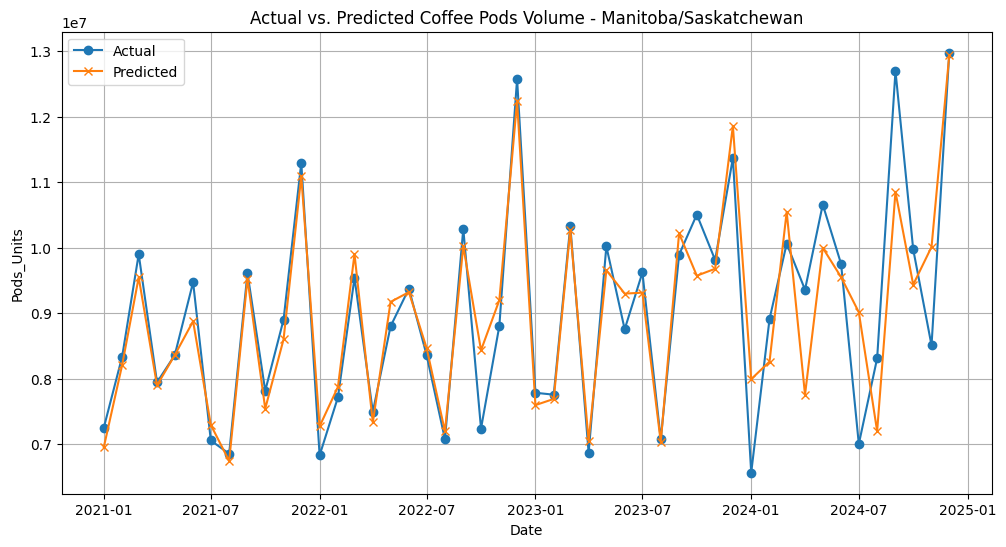

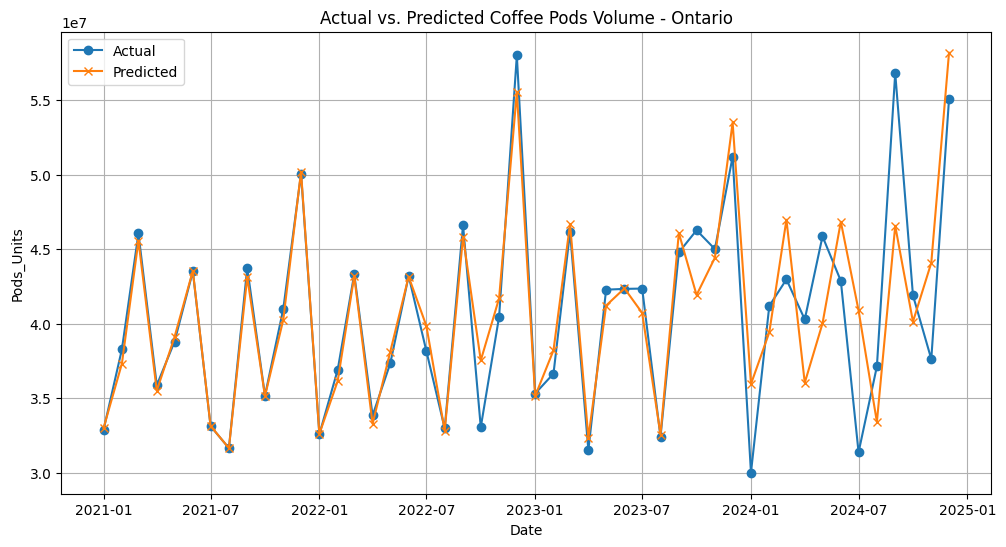

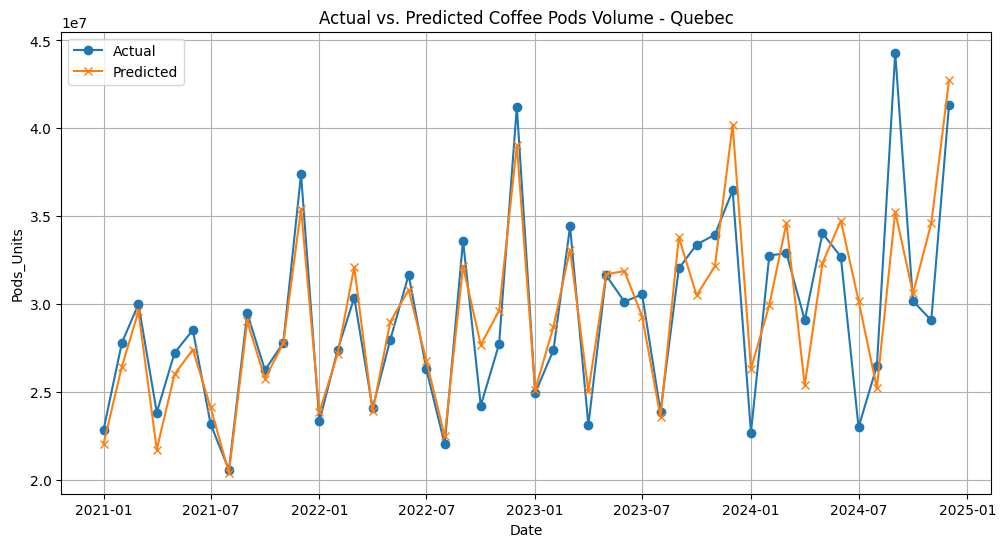

In [ ]:
import matplotlib.pyplot as plt

def plot_final_results(final_results):
    """
    Plots actual vs. predicted values for each region in the final_results DataFrame.

    Args:
        final_results (pd.DataFrame): DataFrame containing 'Region', 'Timestamp_Index',
                                        'Actual', and 'Prediction' columns.
    """
    regions = final_results['Region'].unique()

    for region in regions:
        region_data = final_results[final_results['Region'] == region]

        plt.figure(figsize=(12, 6))
        plt.plot(region_data['Date'], region_data['Actual'], label='Actual', marker='o')
        plt.plot(region_data['Date'], region_data['Prediction'], label='Predicted', marker='x')

        plt.title(f'Actual vs. Predicted Coffee Pods Volume - {region}')
        plt.xlabel('Date')
        plt.ylabel('Pods_Units')
        plt.legend()
        plt.grid(True)
        plt.show()


plot_final_results(final_results)

Best Parameters: {'n_estimators': 10, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8}


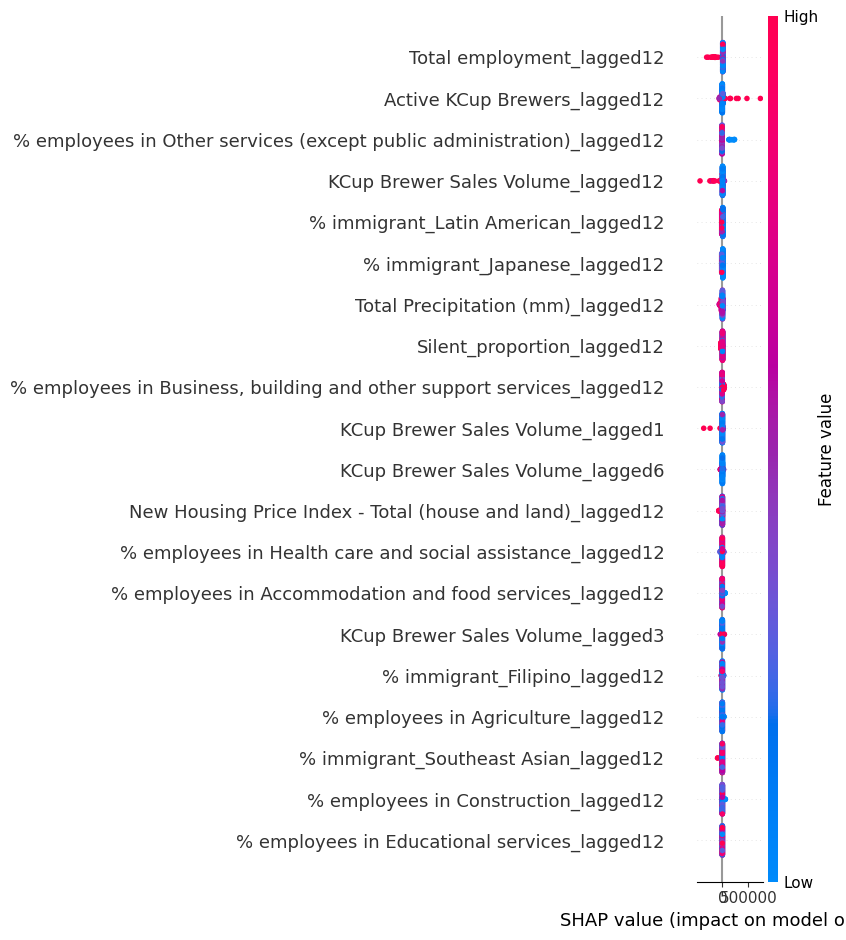


Adjusted Forecast Evaluation
MAPE: 11.50%
RMSE: 16037491.92
R2 Score: 0.531

Prediction Evaluation
MAPE: 11.60%
RMSE: 16085507.25
R2 Score: 0.528


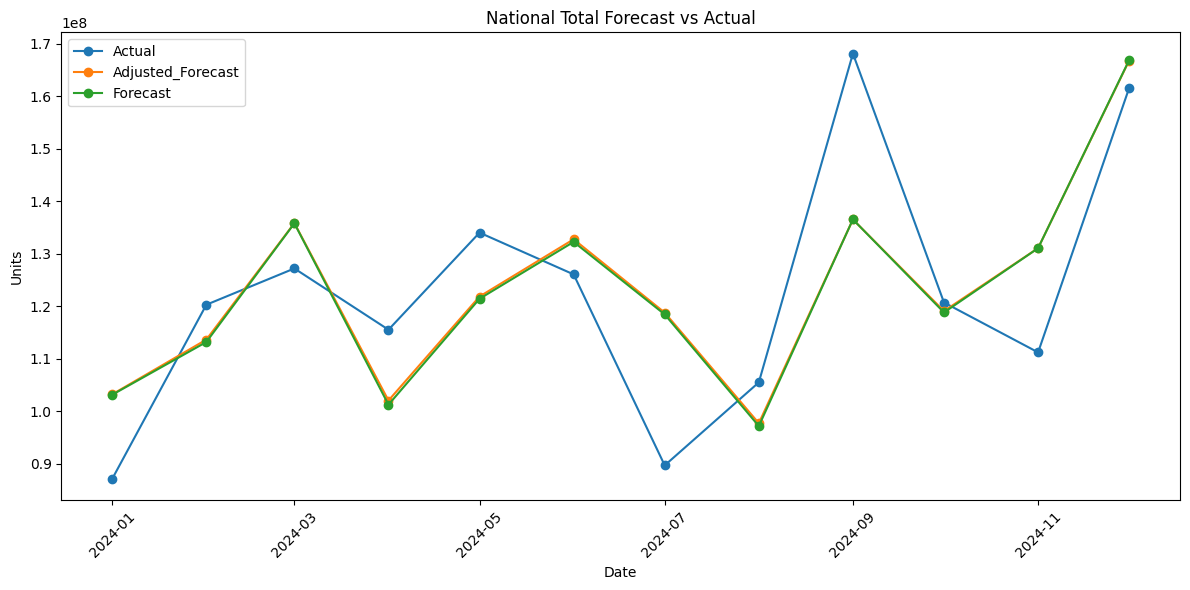

Original feature names count: 74
Original importances count: 74
Adjusted feature names count: 74
Adjusted importances count: 74
Filtered feature names count: 19
Filtered importances count: 19


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
#! pip install shap
import shap
import matplotlib.pyplot as plt

def predict_residuals(residuals, external_data):
    """Use external features to predict the residuals using XGBoost"""

    # Merge residuals and the external data
    combined_data = residuals.merge(external_data, on=['Date', 'Region'], how='left')
    combined_copy = combined_data.copy()
    combined_copy['Month'] = combined_copy['Date'].dt.month

    # Dummify region and month
    combined_copy = pd.get_dummies(combined_copy, columns=['Region', 'Month'])

    unique_dates = sorted(combined_copy['Date'].unique())

    # Split data into train test (last 12 dates as test)
    train_data = combined_copy[~combined_copy['Date'].isin(unique_dates[-12:])]
    test_data = combined_copy[combined_copy['Date'].isin(unique_dates[-12:])]

    # Set up variables
    features = [col for col in combined_copy.columns if col not in ['Date', 'Actual', 'Prediction', 'Residual']]
    y_train, y_test = train_data['Residual'], test_data['Residual']
    X_train, X_test = train_data[features], test_data[features]

    # Define parameter for tuning
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [2, 3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }

    # Function to perform cross-validation manually
    def cross_val(X, y, params):
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []

        for train_index, val_index in kf.split(X):
            X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

            model = xgb.XGBRegressor(eval_metric='mape', **params, random_state=42)
            model.fit(X_train_fold, y_train_fold)

            y_pred = model.predict(X_val_fold)
            score = mean_absolute_percentage_error(y_val_fold, y_pred)
            scores.append(score)

        return np.mean(scores)

    # Manually tune hyperparameters
    best_score = float('inf')
    best_params = None

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                for subsample in param_grid['subsample']:
                    params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'subsample': subsample
                    }

                    score = cross_val(X_train, y_train, params)

                    if score < best_score:
                        best_score = score
                        best_params = params

    print(f"Best Parameters: {best_params}")

    X_train_encoded = X_train.copy()
    X_bool = X_train_encoded.select_dtypes(include=['boolean'])
    X_train_encoded[X_bool.columns] = X_bool.astype(float)

    # Train best model on X_train
    best_xgb = xgb.XGBRegressor(**best_params, eval_metric='mape', random_state=42)
    best_xgb.fit(X_train, y_train)

    # Store feature importance
    importances = best_xgb.feature_importances_

    # Plot SHAP
    explainer = shap.Explainer(best_xgb, X_train_encoded)
    shap_values = explainer(X_train_encoded)
    shap.summary_plot(shap_values, X_train_encoded)

    # Predict residuals
    residual_predictions = best_xgb.predict(X_test)

    # Create residuals_pred DataFrame
    residuals_pred = combined_data[combined_data['Date'].isin(unique_dates[-12:])].copy()
    residuals_pred['Predicted_Residual'] = residual_predictions
    residuals_pred['Adjusted_Forecast'] = residuals_pred['Prediction'] + residuals_pred['Predicted_Residual']

    return residuals_pred, importances, features  # Return importances

def evaluate_predictions(y_true, y_pred, title="Model Evaluation"):
    """Evaluate prediction results"""
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n{title}")
    print(f"MAPE: {mape:.2%}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.3f}")

    return {'mape': mape, 'rmse': rmse, 'r2': r2}

def plot_forecast_vs_actual(forecasts, title=None):
    """Visualize forecast results vs actual values (aggregated across regions)"""

    # Aggregate data by date
    aggregated_data = forecasts.groupby('Date').agg({
        'Actual': 'sum',
        'Prediction': 'sum',
        'Adjusted_Forecast': 'sum'
    }).reset_index()

    title = title or "National Total Forecast vs Actual"

    plt.figure(figsize=(12, 6))
    plt.plot(aggregated_data['Date'], aggregated_data['Actual'], label='Actual', marker='o')
    plt.plot(aggregated_data['Date'], aggregated_data['Adjusted_Forecast'], label='Adjusted_Forecast', marker='o')
    plt.plot(aggregated_data['Date'], aggregated_data['Prediction'], label='Forecast', marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Units')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_importances(importances, feature_names):
    print(f"Original feature names count: {len(feature_names)}")
    print(f"Original importances count: {len(importances)}")

    # Ensure importances and feature_names have the same length
    min_length = min(len(importances), len(feature_names))
    importances = importances[:min_length]
    feature_names = feature_names[:min_length]

    print(f"Adjusted feature names count: {len(feature_names)}")
    print(f"Adjusted importances count: {len(importances)}")

    # Use indices for filtering
    nonzero_indices = np.nonzero(importances)[0]
    filtered_feature_names = [feature_names[i] for i in nonzero_indices]
    filtered_importances = importances[nonzero_indices]

    print(f"Filtered feature names count: {len(filtered_feature_names)}")
    print(f"Filtered importances count: {len(filtered_importances)}")

    if len(filtered_feature_names) != len(filtered_importances):
        print("Error: Mismatch in feature names and importance values after filtering.")
        return

    feature_importance_df = pd.DataFrame({
        'Feature': filtered_feature_names,
        'Importance': filtered_importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 15))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance - XGBoost')
    plt.gca().invert_yaxis()
    plt.show()

# Load data
external_data = pd.read_csv('/content/used_external_features.csv')
external_data['Date'] = pd.to_datetime(external_data['Date'])

# Call function
residuals_pred, importances, features = predict_residuals(final_results, external_data)

# Aggregate data for evaluation
aggregated_data = residuals_pred.groupby('Date').agg({
    'Actual': 'sum',
    'Prediction': 'sum',
    'Adjusted_Forecast': 'sum'
}).reset_index()

# Evaluate predictions
evaluation_results = evaluate_predictions(aggregated_data['Actual'], aggregated_data['Adjusted_Forecast'], title="Adjusted Forecast Evaluation")
evaluation_results_prediction = evaluate_predictions(aggregated_data['Actual'], aggregated_data['Prediction'], title = "Prediction Evaluation")

# Plot forecast vs actual (aggregated)
plot_forecast_vs_actual(residuals_pred)

# Plot feature importances
#feature_names = [col for col in residuals_pred.columns if col not in ['Date', 'Actual', 'Prediction', 'Residual', 'Predicted_Residual', 'Adjusted_Forecast']]
plot_importances(importances, features)

## DSAttention in addition to normalisation introduced to the non-stationary transformer

In [ ]:
import torch
import torch.nn as nn

class DSAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout=0.1):
        super(DSAttention, self).__init__()
        self.n_heads = n_heads
        self.d_model = d_model

        # Separate attention heads for trend and seasonal components
        self.trend_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, dropout=dropout, batch_first=True)
        self.seasonal_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=n_heads, dropout=dropout, batch_first=True)

        # Adaptive weighting of trend and seasonal components
        self.trend_weight = nn.Parameter(torch.ones(1))
        self.seasonal_weight = nn.Parameter(torch.ones(1))

    def forward(self, query, key, value):
        trend_out, _ = self.trend_attention(query, key, value)
        seasonal_out, _ = self.seasonal_attention(query, key, value)

        # Combine trend and seasonal attention outputs
        output = self.trend_weight * trend_out + self.seasonal_weight * seasonal_out
        return output


class NonStationaryTransformer(nn.Module):
    def __init__(self, configs):
        super(NonStationaryTransformer, self).__init__()
        self.seq_len = configs.seq_len  # Example: 24
        self.pred_len = configs.pred_len  # Example: 12
        self.d_model = configs.d_model
        self.nhead = configs.nhead
        self.num_encoder_layers = configs.num_encoder_layers
        self.num_decoder_layers = configs.num_decoder_layers
        self.dropout = configs.dropout

        # Embedding layers
        self.encoder_embedding = nn.Linear(1, self.d_model)
        self.decoder_embedding = nn.Linear(1, self.d_model)

        # Time Embedding
        self.time_embedding = nn.Embedding(self.seq_len + self.pred_len, self.d_model)

        # DSAttention Mechanism
        self.ds_attention = DSAttention(d_model=self.d_model, n_heads=self.nhead, dropout=self.dropout)

        # Adaptive Normalization
        self.adaptive_norm = nn.LayerNorm(self.d_model)

        # Sophisticated Trend and Seasonal Components
        self.trend_layer = nn.Sequential(
            nn.Linear(self.seq_len, 64),
            nn.ReLU(),
            nn.Linear(64, self.pred_len)
        )
        self.seasonal_layer = nn.Sequential(
            nn.Linear(self.seq_len, 64),
            nn.ReLU(),
            nn.Linear(64, self.pred_len)
        )

        # Output layer
        self.fc_out = nn.Linear(self.d_model, 1)

    def forward(self, encoder_input, decoder_input):
        batch_size = encoder_input.shape[0]

        encoder_embedded = self.encoder_embedding(encoder_input)
        decoder_embedded = self.decoder_embedding(decoder_input)

        # Create time indices for embedding
        encoder_time_indices = torch.arange(self.seq_len, device=encoder_input.device).unsqueeze(0).repeat(batch_size, 1)
        decoder_time_indices = torch.arange(self.pred_len, device=decoder_input.device).unsqueeze(0).repeat(batch_size, 1)  # Fix

        # Add time embeddings
        encoder_embedded += self.time_embedding(encoder_time_indices)
        decoder_embedded += self.time_embedding(decoder_time_indices)

        # Apply DSAttention only to encoder
        attention_output = self.ds_attention(encoder_embedded, encoder_embedded, encoder_embedded)

        # Adaptive Normalization
        normalized_output = self.adaptive_norm(attention_output)

        # Ensure fc_out processes only the last `pred_len` time steps
        output = self.fc_out(normalized_output[:, -self.pred_len:, :])  # Fix: match pred_len size

        # Trend and Seasonal Components
        trend = self.trend_layer(encoder_input.squeeze(-1)).unsqueeze(-1)  # Ensure shape matches
        seasonal = self.seasonal_layer(encoder_input.squeeze(-1)).unsqueeze(-1)

        output = output + trend + seasonal

        return output


# Configuration
class Configs:
    def __init__(self):
        self.seq_len = 24
        self.pred_len = 12
        self.d_model = 64
        self.nhead = 4
        self.num_encoder_layers = 2
        self.num_decoder_layers = 2
        self.dropout = 0.1
        self.batch_size = 36
        self.lr = 0.001
        self.num_epochs = 500

configs = Configs()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RollingWindowDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, region):
        self.df = df[df['Region'] == region].reset_index(drop=True)
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.data_len = len(self.df)
        self.start_offset = (self.data_len - self.pred_len - self.seq_len) % self.pred_len

    def __len__(self):
        if self.data_len >= self.seq_len + self.pred_len + self.start_offset:
            return (self.data_len - self.seq_len - self.pred_len - self.start_offset) // self.pred_len + 1
        else:
            return 0

    def __getitem__(self, idx):
        start_idx = idx * self.pred_len + self.start_offset
        end_idx = start_idx + self.seq_len + self.pred_len

        encoder_input = self.df['Pods_Units'].iloc[start_idx : start_idx + self.seq_len].values
        decoder_input = self.df['Pods_Units'].iloc[start_idx + self.seq_len : end_idx].values
        target = self.df['Pods_Units'].iloc[start_idx + self.seq_len : end_idx].values
        #dates = self.df['Date'].iloc[start_idx + self.seq_len : end_idx].values

        encoder_input = torch.tensor(encoder_input, dtype=torch.float32).unsqueeze(-1)
        decoder_input = torch.tensor(decoder_input, dtype=torch.float32).unsqueeze(-1)
        target = torch.tensor(target, dtype=torch.float32)

        return encoder_input, decoder_input, target
        #return encoder_input, decoder_input, target, dates

def train_test_split(df, configs):
    region_dataloaders = {}
    regions = df['Region'].unique()

    for region in regions:
        region_df = df[df['Region'] == region].reset_index(drop=True)
        data_len = len(region_df)

        # Last 12 months for testing
        test_len = configs.pred_len
        train_len = data_len - test_len

        # Create training dataset
        train_dataset = RollingWindowDataset(region_df.iloc[:train_len], configs.seq_len, configs.pred_len, region)
        train_loader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=False)

        # Create test dataset
        test_data = region_df.iloc[train_len - configs.seq_len:] # to include seq_len months before test set
        test_encoder_input = test_data['Pods_Units'].iloc[:configs.seq_len].values # last seq months of training data
        test_decoder_input = test_data['Pods_Units'].iloc[configs.seq_len:].values # test set data
        test_target = test_data['Pods_Units'].iloc[configs.seq_len:].values # test set data
        #test_dates = test_data['Date'].iloc[configs.seq_len:].values

        # Convert test data to tensors
        test_encoder_input = torch.tensor(test_encoder_input, dtype=torch.float32).unsqueeze(-1)
        test_decoder_input = torch.tensor(test_decoder_input, dtype=torch.float32).unsqueeze(-1)
        test_target = torch.tensor(test_target, dtype=torch.float32)

        # Create test dataset
        test_batch = [(test_encoder_input, test_decoder_input, test_target)]
        #test_dataset = torch.utils.data.TensorDataset(test_encoder_input, test_decoder_input, test_target)
        test_loader = DataLoader(test_batch, batch_size=1, shuffle=False)

        region_dataloaders[region] = {'train': train_loader, 'test': test_loader}

    return region_dataloaders

def train(region_dataloaders, configs):
    region_models = {}

    for region, dataloaders in region_dataloaders.items():
        model = NonStationaryTransformer(configs).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=configs.lr)

        train_loader = dataloaders['train']

        for epoch in range(configs.num_epochs):
            model.train()
            train_loss = 0.0

            for encoder_input, decoder_input, target in train_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                optimizer.zero_grad()
                output = model(encoder_input, decoder_input).squeeze(-1)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            if (epoch + 1) % 100 ==0:
                print(f"Region: {region}, Epoch: {epoch+1}, Loss: {train_loss/len(train_loader)}")

        region_models[region] = model

    return region_models

def evaluate(region_models, region_dataloaders, configs):
    test_results = {}

    for region, model in region_models.items():
        model.eval()
        criterion = nn.MSELoss()
        test_loader = region_dataloaders[region]['test']

        total_loss = 0.0

        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                output = model(encoder_input, decoder_input).squeeze(-1)
                loss = criterion(output, target)
                total_loss += loss.item()

        #print(len(test_loader))
        test_results[region] = total_loss

    return test_results

def predict_combine(region_models, df, configs):
    '''
    Generate predictions for each rolling window using the trained models, calculate residuals,
    and combine into a single DataFrame. Also calculate overall MAPE and final prediction MAPE.
    '''
    combined_results = []
    overall_actuals = []
    overall_predictions = []
    final_pred_actuals = []
    final_pred_predictions = []

    for region, model in region_models.items():
        model.eval()
        region_df = df[df['Region'] == region].copy().reset_index(drop=True)

        predictions = []
        actuals = []
        time_indices = []
        #dates = []

        # Create dataset for the region
        region_dataset = RollingWindowDataset(
            df=region_df,
            seq_len=configs.seq_len,
            pred_len=configs.pred_len,
            region=region
        )
        region_loader = DataLoader(region_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for idx, (encoder_input, decoder_input, target) in enumerate(region_loader):
            #for encoder_input, decoder_input, target in region_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                # Forward pass
                output = model(encoder_input, decoder_input).squeeze(-1)

                # Store predictions, actual values, and time indices
                predictions.extend(output.cpu().numpy().flatten())
                actuals.extend(target.cpu().numpy().flatten())
                #dates.extend(window_dates)

                # Calculate time indices
                start_idx = region_dataset.start_offset + idx * configs.pred_len
                window_indices = region_df.index[start_idx + configs.seq_len : start_idx + configs.pred_len + configs.seq_len]
                time_indices.extend(window_indices.tolist())  # Use start indices for time indices

        # Calculate residuals
        predictions = np.array(predictions)
        actuals = np.array(actuals)
        residuals = actuals - predictions

        # Store overall actuals and predictions for overall MAPE
        overall_actuals.extend(actuals)
        overall_predictions.extend(predictions)

        # Store final prediction actuals and predictions
        final_pred_actuals.append(actuals[-configs.pred_len:])
        final_pred_predictions.append(predictions[-configs.pred_len:])

        # Create DataFrame for region results
        region_results = pd.DataFrame({
            'Region': region,
            'Timestamp_Index': time_indices,
            #'Date': dates,
            'Actual': actuals,
            'Prediction': predictions,
            'Residual': residuals
        })

        # Append region results to combined results
        combined_results.append(region_results)

    # Combine all results into a single DataFrame
    final_results = pd.concat(combined_results, ignore_index=True)

    # Merge with original df to get corresponding dates
    final_results = final_results.merge(df[['Date']].reset_index(), left_on=['Timestamp_Index'], right_on='index', how='left').drop(columns=['index', 'Timestamp_Index'])

    # Overall MAPE across all regions
    overall_mape = np.mean(np.abs((np.array(overall_actuals) - np.array(overall_predictions)) / np.array(overall_actuals))) * 100

    # Final prediction MAPE (for the final round of predictions)
    final_pred_mape = np.mean(np.abs((np.array(final_pred_actuals) - np.array(final_pred_predictions)) / np.array(final_pred_actuals))) * 100

    return final_results, overall_mape, final_pred_mape

# Pre-processing
df = pd.read_excel("/content/KCUP_Brand_Categorized_Volume.xlsx")

# Preprocess data
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Region'] != 'West']
df = df.groupby(['Region', 'Date'], as_index=False)['Pods_Units'].sum()

# Sort data by Region and Date
df = df.sort_values(by=['Region', 'Date']).reset_index(drop=True)
df['Timestamp_Index'] = (df['Date'].dt.year - 2019) * 12 + (df['Date'].dt.month - 1)

# Create dataloaders for rolling window
region_dataloader = train_test_split(df, configs)  # Use the correct function name

# Train models for each region
region_models = train(region_dataloader, configs)

# Test models and get test results
test_results = evaluate(region_models, region_dataloader, configs)  # Use the correct function name

# Generate predictions and calculate MAPE
final_results, overall_mape, final_pred_mape = predict_combine(region_models, df, configs)

print("Overall MAPE:", overall_mape)
print("Final Prediction MAPE:", final_pred_mape)

final_results.head(10)

Region: Alberta, Epoch: 100, Loss: 1774623784960.0
Region: Alberta, Epoch: 200, Loss: 1196946096128.0
Region: Alberta, Epoch: 300, Loss: 742750945280.0
Region: Alberta, Epoch: 400, Loss: 466806407168.0
Region: Alberta, Epoch: 500, Loss: 300976340992.0
Region: Atlantic, Epoch: 100, Loss: 569923403776.0
Region: Atlantic, Epoch: 200, Loss: 472833032192.0
Region: Atlantic, Epoch: 300, Loss: 378250625024.0
Region: Atlantic, Epoch: 400, Loss: 294815662080.0
Region: Atlantic, Epoch: 500, Loss: 227723591680.0
Region: British Columbia, Epoch: 100, Loss: 954002046976.0
Region: British Columbia, Epoch: 200, Loss: 788932329472.0
Region: British Columbia, Epoch: 300, Loss: 614654083072.0
Region: British Columbia, Epoch: 400, Loss: 453362417664.0
Region: British Columbia, Epoch: 500, Loss: 327999651840.0
Region: Manitoba/Saskatchewan, Epoch: 100, Loss: 596012433408.0
Region: Manitoba/Saskatchewan, Epoch: 200, Loss: 412003500032.0
Region: Manitoba/Saskatchewan, Epoch: 300, Loss: 264269611008.0
Region

Region      Actual  Prediction  Residual       Date
0  Alberta  14070551.0  13802451.0  268100.0 2021-01-01
1  Alberta  15638987.0  15415104.0  223883.0 2021-02-01
2  Alberta  18508944.0  18524128.0  -15184.0 2021-03-01
3  Alberta  14942322.0  15004218.0  -61896.0 2021-04-01
4  Alberta  15772950.0  15496094.0  276856.0 2021-05-01
5  Alberta  17648356.0  17132536.0  515820.0 2021-06-01
6  Alberta  12506010.0  12480395.0   25615.0 2021-07-01
7  Alberta  12402535.0  12469282.0  -66747.0 2021-08-01
8  Alberta  17891352.0  18018300.0 -126948.0 2021-09-01
9  Alberta  14318364.0  14091580.0  226784.0 2021-10-01

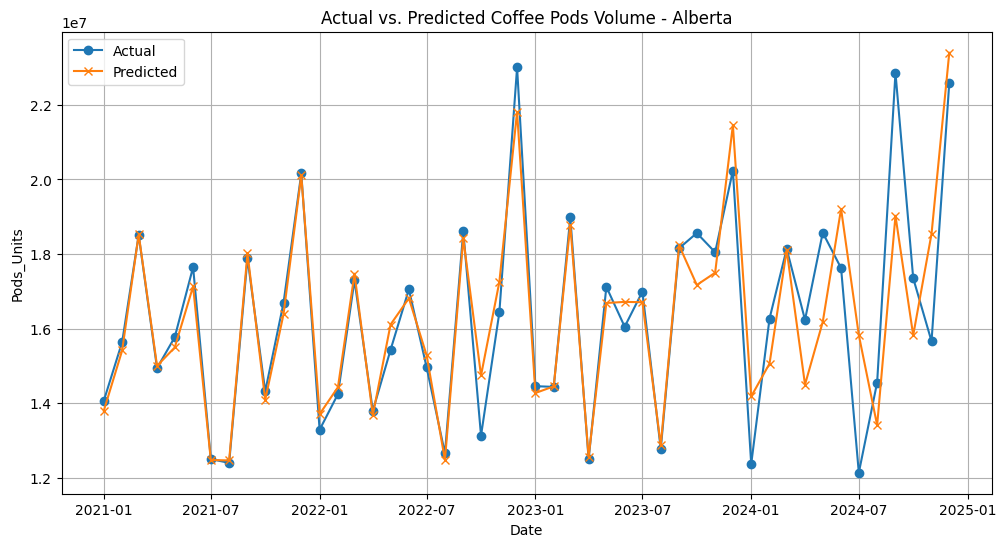

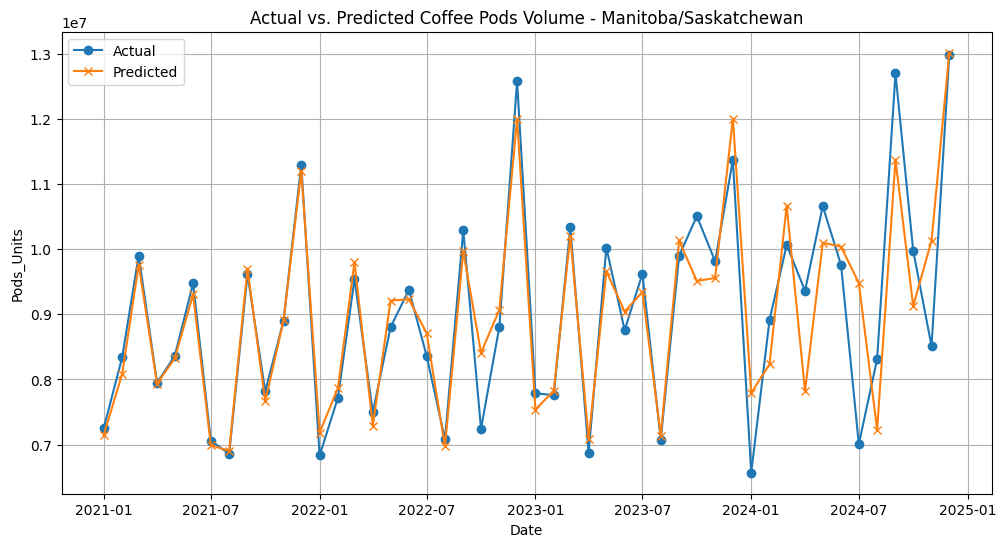

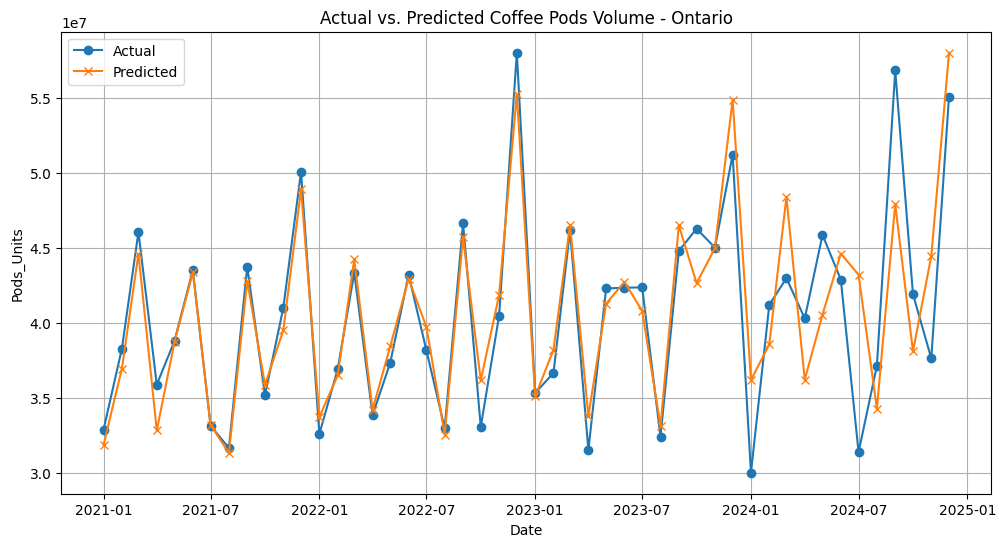

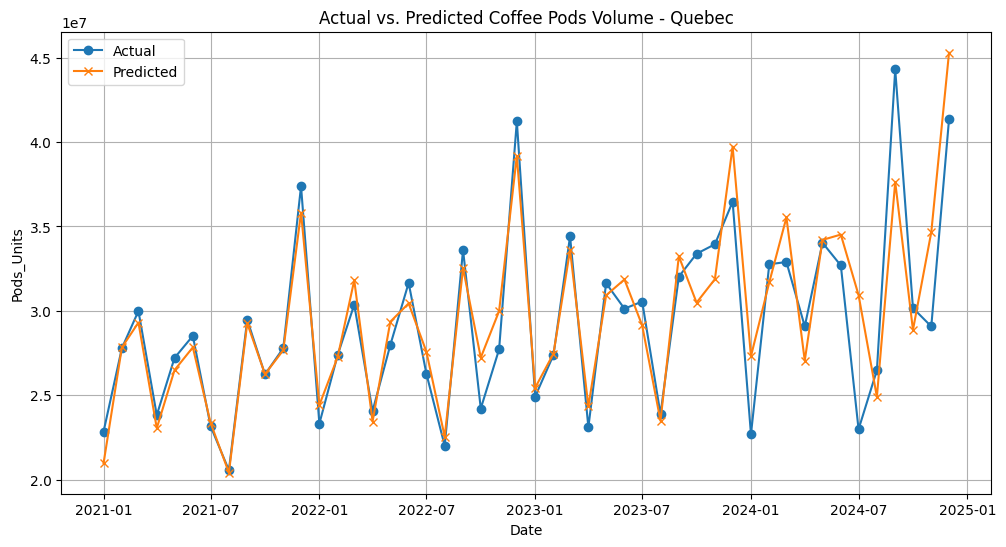

In [ ]:
import matplotlib.pyplot as plt

def plot_final_results(final_results):
    """
    Plots actual vs. predicted values for each region in the final_results DataFrame.

    Args:
        final_results (pd.DataFrame): DataFrame containing 'Region', 'Timestamp_Index',
                                        'Actual', and 'Prediction' columns.
    """
    regions = final_results['Region'].unique()

    for region in regions:
        region_data = final_results[final_results['Region'] == region]

        plt.figure(figsize=(12, 6))
        plt.plot(region_data['Date'], region_data['Actual'], label='Actual', marker='o')
        plt.plot(region_data['Date'], region_data['Prediction'], label='Predicted', marker='x')

        plt.title(f'Actual vs. Predicted Coffee Pods Volume - {region}')
        plt.xlabel('Date')
        plt.ylabel('Pods_Units')
        plt.legend()
        plt.grid(True)
        plt.show()


plot_final_results(final_results)

### External data modelling on residual

Best Parameters: {'n_estimators': 10, 'max_depth': 2, 'learning_rate': 0.05, 'subsample': 1.0}


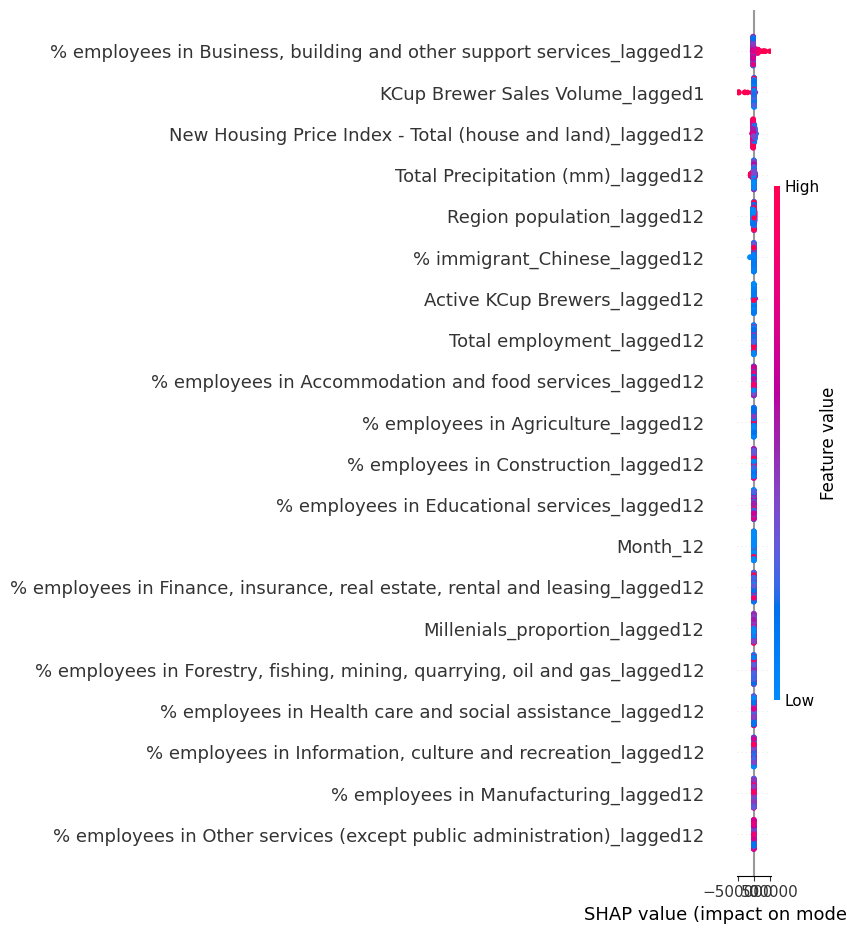


Adjusted Forecast Evaluation
MAPE: 12.05%
RMSE: 16026464.06
R2 Score: 0.532

Prediction Evaluation
MAPE: 12.11%
RMSE: 16077177.77
R2 Score: 0.529


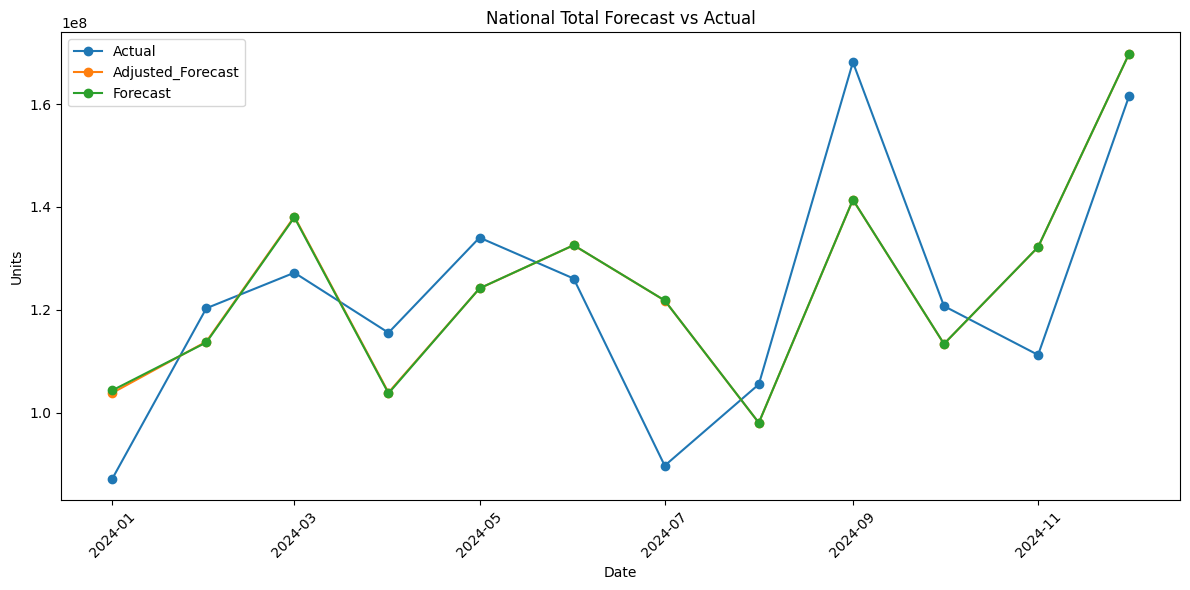

Original feature names count: 74
Original importances count: 74
Adjusted feature names count: 74
Adjusted importances count: 74
Filtered feature names count: 7
Filtered importances count: 7


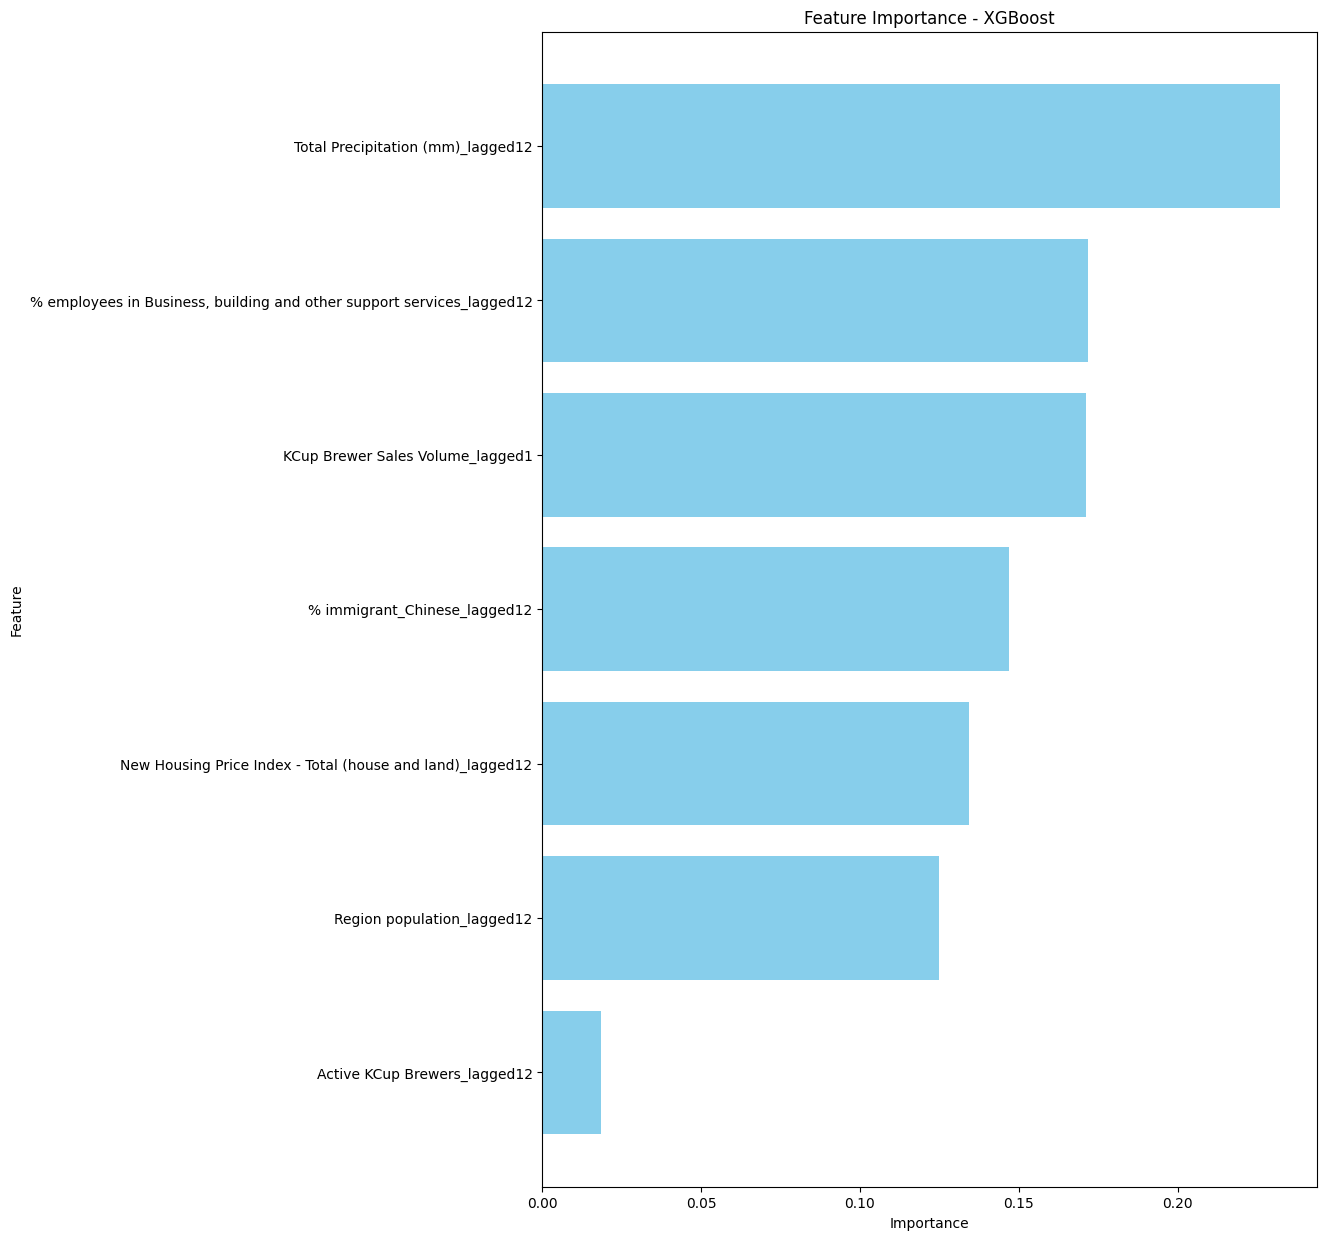

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
#! pip install shap
import shap
import matplotlib.pyplot as plt

def predict_residuals(residuals, external_data):
    """Use external features to predict the residuals using XGBoost"""

    # Merge residuals and the external data
    combined_data = residuals.merge(external_data, on=['Date', 'Region'], how='left')
    combined_copy = combined_data.copy()
    combined_copy['Month'] = combined_copy['Date'].dt.month

    # Dummify region and month
    combined_copy = pd.get_dummies(combined_copy, columns=['Region', 'Month'])

    unique_dates = sorted(combined_copy['Date'].unique())

    # Split data into train test (last 12 dates as test)
    train_data = combined_copy[~combined_copy['Date'].isin(unique_dates[-12:])]
    test_data = combined_copy[combined_copy['Date'].isin(unique_dates[-12:])]

    # Set up variables
    features = [col for col in combined_copy.columns if col not in ['Date', 'Actual', 'Prediction', 'Residual']]
    y_train, y_test = train_data['Residual'], test_data['Residual']
    X_train, X_test = train_data[features], test_data[features]

    # Define parameter for tuning
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [2, 3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }

    # Function to perform cross-validation manually
    def cross_val(X, y, params):
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []

        for train_index, val_index in kf.split(X):
            X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

            model = xgb.XGBRegressor(eval_metric='mape', **params, random_state=42)
            model.fit(X_train_fold, y_train_fold)

            y_pred = model.predict(X_val_fold)
            score = mean_absolute_percentage_error(y_val_fold, y_pred)
            scores.append(score)

        return np.mean(scores)

    # Manually tune hyperparameters
    best_score = float('inf')
    best_params = None

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                for subsample in param_grid['subsample']:
                    params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'subsample': subsample
                    }

                    score = cross_val(X_train, y_train, params)

                    if score < best_score:
                        best_score = score
                        best_params = params

    print(f"Best Parameters: {best_params}")

    X_train_encoded = X_train.copy()
    X_bool = X_train_encoded.select_dtypes(include=['boolean'])
    X_train_encoded[X_bool.columns] = X_bool.astype(float)

    # Train best model on X_train
    best_xgb = xgb.XGBRegressor(**best_params, eval_metric='mape', random_state=42)
    best_xgb.fit(X_train, y_train)

    # Store feature importance
    importances = best_xgb.feature_importances_

    # Plot SHAP
    explainer = shap.Explainer(best_xgb, X_train_encoded)
    shap_values = explainer(X_train_encoded)
    shap.summary_plot(shap_values, X_train_encoded)

    # Predict residuals
    residual_predictions = best_xgb.predict(X_test)

    # Create residuals_pred DataFrame
    residuals_pred = combined_data[combined_data['Date'].isin(unique_dates[-12:])].copy()
    residuals_pred['Predicted_Residual'] = residual_predictions
    residuals_pred['Adjusted_Forecast'] = residuals_pred['Prediction'] + residuals_pred['Predicted_Residual']

    return residuals_pred, importances, features  # Return importances

def evaluate_predictions(y_true, y_pred, title="Model Evaluation"):
    """Evaluate prediction results"""
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n{title}")
    print(f"MAPE: {mape:.2%}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.3f}")

    return {'mape': mape, 'rmse': rmse, 'r2': r2}

def plot_forecast_vs_actual(forecasts, title=None):
    """Visualize forecast results vs actual values (aggregated across regions)"""

    # Aggregate data by date
    aggregated_data = forecasts.groupby('Date').agg({
        'Actual': 'sum',
        'Prediction': 'sum',
        'Adjusted_Forecast': 'sum'
    }).reset_index()

    title = title or "National Total Forecast vs Actual"

    plt.figure(figsize=(12, 6))
    plt.plot(aggregated_data['Date'], aggregated_data['Actual'], label='Actual', marker='o')
    plt.plot(aggregated_data['Date'], aggregated_data['Adjusted_Forecast'], label='Adjusted_Forecast', marker='o')
    plt.plot(aggregated_data['Date'], aggregated_data['Prediction'], label='Forecast', marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Units')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_importances(importances, feature_names):
    print(f"Original feature names count: {len(feature_names)}")
    print(f"Original importances count: {len(importances)}")

    # Ensure importances and feature_names have the same length
    min_length = min(len(importances), len(feature_names))
    importances = importances[:min_length]
    feature_names = feature_names[:min_length]

    print(f"Adjusted feature names count: {len(feature_names)}")
    print(f"Adjusted importances count: {len(importances)}")

    # Use indices for filtering
    nonzero_indices = np.nonzero(importances)[0]
    filtered_feature_names = [feature_names[i] for i in nonzero_indices]
    filtered_importances = importances[nonzero_indices]

    print(f"Filtered feature names count: {len(filtered_feature_names)}")
    print(f"Filtered importances count: {len(filtered_importances)}")

    if len(filtered_feature_names) != len(filtered_importances):
        print("Error: Mismatch in feature names and importance values after filtering.")
        return

    feature_importance_df = pd.DataFrame({
        'Feature': filtered_feature_names,
        'Importance': filtered_importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 15))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance - XGBoost')
    plt.gca().invert_yaxis()
    plt.show()

# Load data
external_data = pd.read_csv('/content/used_external_features.csv')
external_data['Date'] = pd.to_datetime(external_data['Date'])

# Call function
residuals_pred, importances, features = predict_residuals(final_results, external_data)

# Aggregate data for evaluation
aggregated_data = residuals_pred.groupby('Date').agg({
    'Actual': 'sum',
    'Prediction': 'sum',
    'Adjusted_Forecast': 'sum'
}).reset_index()

# Evaluate predictions
evaluation_results = evaluate_predictions(aggregated_data['Actual'], aggregated_data['Adjusted_Forecast'], title="Adjusted Forecast Evaluation")
evaluation_results_prediction = evaluate_predictions(aggregated_data['Actual'], aggregated_data['Prediction'], title = "Prediction Evaluation")

# Plot forecast vs actual (aggregated)
plot_forecast_vs_actual(residuals_pred)

# Plot feature importances
#feature_names = [col for col in residuals_pred.columns if col not in ['Date', 'Actual', 'Prediction', 'Residual', 'Predicted_Residual', 'Adjusted_Forecast']]
plot_importances(importances, features)

In [ ]:
residuals_pred[['Region', 'Actual', 'Prediction', 'Residual', 'Date', 'Predicted_Residual', 'Adjusted_Forecast']]

Region      Actual  Prediction   Residual       Date  \
36   Alberta  12369389.0  14184238.0 -1814849.0 2024-01-01   
37   Alberta  16270918.0  15064130.0  1206788.0 2024-02-01   
38   Alberta  18138614.0  18103878.0    34736.0 2024-03-01   
39   Alberta  16236229.0  14500174.0  1736055.0 2024-04-01   
40   Alberta  18572124.0  16178888.0  2393236.0 2024-05-01   
..       ...         ...         ...        ...        ...   
283   Quebec  26489974.0  24911374.0  1578600.0 2024-08-01   
284   Quebec  44299272.0  37637044.0  6662228.0 2024-09-01   
285   Quebec  30171770.0  28872752.0  1299018.0 2024-10-01   
286   Quebec  29081094.0  34659944.0 -5578850.0 2024-11-01   
287   Quebec  41337912.0  45285032.0 -3947120.0 2024-12-01   

     Predicted_Residual  Adjusted_Forecast  
36         -1524.360596         14182714.0  
37         -1524.360596         15062606.0  
38         -1524.360596         18102354.0  
39         -1524.360596         14498650.0  
40         -1524.360596         16177364.0  
..                  ...                ...  
283        -1524.360596         24909850.0  
284        -1524.360596         37635520.0  
285        -1524.360596         28871228.0  
286        -1524.360596         34658420.0  
287        -1524.360596         45283508.0  

[72 rows x 7 columns]

# [not chosen]
### Even more elements of non stationary introduced for time series modelling
Dual-Stream Attention: Explicitly models trend and seasonality, allowing the model to dynamically adjust their contributions.

Improved Normalization: LayerNorm stabilizes training and is better suited for transformers.

Proper Trend & Seasonal Processing: Conditions trend and seasonality on decoder_input, making it consistent with forecasting tasks.

In [ ]:
import torch
import torch.nn as nn

class DSAttention(nn.Module):
    def __init__(self, d_model, n_heads, dropout):
        super(DSAttention, self).__init__()
        self.trend_attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.seasonal_attention = nn.MultiheadAttention(d_model, n_heads, dropout=dropout)
        self.trend_weight = nn.Parameter(torch.tensor(0.5))  # Learnable weight for trend
        self.seasonal_weight = nn.Parameter(torch.tensor(0.5))  # Learnable weight for seasonality

    def forward(self, query, key, value):
        # Trend attention
        trend_output, _ = self.trend_attention(query, key, value)

        # Seasonal attention
        seasonal_output, _ = self.seasonal_attention(query, key, value)

        # Combine trend and seasonal outputs using learnable weights
        output = self.trend_weight * trend_output + self.seasonal_weight * seasonal_output
        return output

class NonStationaryTransformer(nn.Module):
    def __init__(self, configs):
        super(NonStationaryTransformer, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.d_model = configs.d_model
        self.nhead = configs.nhead
        self.num_encoder_layers = configs.num_encoder_layers
        self.num_decoder_layers = configs.num_decoder_layers
        self.dropout = configs.dropout

        # Embedding layers
        self.encoder_embedding = nn.Linear(1, self.d_model)
        self.decoder_embedding = nn.Linear(1, self.d_model)

        # Time Embedding
        self.time_embedding = nn.Embedding(self.seq_len + self.pred_len, self.d_model)

        # Dual-Stream Attention
        self.ds_attention = DSAttention(d_model=self.d_model, n_heads=self.nhead, dropout=self.dropout)

        # Adaptive Normalization
        self.adaptive_norm = nn.LayerNorm(self.d_model)

        # Trend and Seasonal Components
        self.trend_layer = nn.Sequential(
            nn.Linear(self.pred_len, 64),
            nn.ReLU(),
            nn.LayerNorm(64),  # LayerNorm for stability
            nn.Linear(64, self.pred_len)
        )
        self.seasonal_layer = nn.Sequential(
            nn.Linear(self.pred_len, 64),
            nn.ReLU(),
            nn.LayerNorm(64),  # LayerNorm for stability
            nn.Linear(64, self.pred_len)
        )

        # Output layer
        self.fc_out = nn.Linear(self.d_model, 1)

    def forward(self, encoder_input, decoder_input):
        batch_size = encoder_input.shape[0]

        # Adaptive Normalization
        encoder_mean = encoder_input.mean(dim=1, keepdim=True)
        encoder_std = encoder_input.std(dim=1, keepdim=True)
        encoder_normalized = (encoder_input - encoder_mean) / (encoder_std + 1e-6)

        decoder_mean = decoder_input.mean(dim=1, keepdim=True)
        decoder_std = decoder_input.std(dim=1, keepdim=True)
        decoder_normalized = (decoder_input - decoder_mean) / (decoder_std + 1e-6)

        # Embedding
        encoder_embedded = self.encoder_embedding(encoder_normalized)
        decoder_embedded = self.decoder_embedding(decoder_normalized)

        # Time Embedding
        encoder_time_indices = torch.arange(self.seq_len, device=encoder_input.device).unsqueeze(0).repeat(batch_size, 1)
        decoder_time_indices = torch.arange(self.seq_len, self.seq_len + self.pred_len, device=decoder_input.device).unsqueeze(0).repeat(batch_size, 1)

        encoder_embedded += self.time_embedding(encoder_time_indices)
        decoder_embedded += self.time_embedding(decoder_time_indices)

        # Apply Dual-Stream Attention
        attention_output = self.ds_attention(encoder_embedded, encoder_embedded, encoder_embedded)

        # Adaptive Normalization
        normalized_output = self.adaptive_norm(attention_output)

        # Ensure fc_out processes only the last pred_len time steps
        output = self.fc_out(normalized_output[:, -self.pred_len:, :])

        # Adaptive De-normalization
        output = output * (decoder_std + 1e-6) + decoder_mean

        # Trend and Seasonal Components based on decoder input
        trend = self.trend_layer(decoder_input.squeeze(-1)).unsqueeze(-1)
        seasonal = self.seasonal_layer(decoder_input.squeeze(-1)).unsqueeze(-1)

        output = output + trend + seasonal

        return output

# Configuration
class Configs:
    def __init__(self):
        self.seq_len = 24
        self.pred_len = 12
        self.d_model = 64
        self.nhead = 4
        self.num_encoder_layers = 2
        self.num_decoder_layers = 2
        self.dropout = 0.1
        self.batch_size = 36
        self.lr = 0.001
        self.num_epochs = 500

configs = Configs()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class RollingWindowDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, region):
        self.df = df[df['Region'] == region].reset_index(drop=True)
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.data_len = len(self.df)
        self.start_offset = (self.data_len - self.pred_len - self.seq_len) % self.pred_len

    def __len__(self):
        if self.data_len >= self.seq_len + self.pred_len + self.start_offset:
            return (self.data_len - self.seq_len - self.pred_len - self.start_offset) // self.pred_len + 1
        else:
            return 0

    def __getitem__(self, idx):
        start_idx = idx * self.pred_len + self.start_offset
        end_idx = start_idx + self.seq_len + self.pred_len

        encoder_input = self.df['Pods_Units'].iloc[start_idx : start_idx + self.seq_len].values
        decoder_input = self.df['Pods_Units'].iloc[start_idx + self.seq_len : end_idx].values
        target = self.df['Pods_Units'].iloc[start_idx + self.seq_len : end_idx].values
        #dates = self.df['Date'].iloc[start_idx + self.seq_len : end_idx].values

        encoder_input = torch.tensor(encoder_input, dtype=torch.float32).unsqueeze(-1)
        decoder_input = torch.tensor(decoder_input, dtype=torch.float32).unsqueeze(-1)
        target = torch.tensor(target, dtype=torch.float32)

        return encoder_input, decoder_input, target
        #return encoder_input, decoder_input, target, dates

def train_test_split(df, configs):
    region_dataloaders = {}
    regions = df['Region'].unique()

    for region in regions:
        region_df = df[df['Region'] == region].reset_index(drop=True)
        data_len = len(region_df)

        # Last 12 months for testing
        test_len = configs.pred_len
        train_len = data_len - test_len

        # Create training dataset
        train_dataset = RollingWindowDataset(region_df.iloc[:train_len], configs.seq_len, configs.pred_len, region)
        train_loader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=False)

        # Create test dataset
        test_data = region_df.iloc[train_len - configs.seq_len:] # to include seq_len months before test set
        test_encoder_input = test_data['Pods_Units'].iloc[:configs.seq_len].values # last seq months of training data
        test_decoder_input = test_data['Pods_Units'].iloc[configs.seq_len:].values # test set data
        test_target = test_data['Pods_Units'].iloc[configs.seq_len:].values # test set data
        #test_dates = test_data['Date'].iloc[configs.seq_len:].values

        # Convert test data to tensors
        test_encoder_input = torch.tensor(test_encoder_input, dtype=torch.float32).unsqueeze(-1)
        test_decoder_input = torch.tensor(test_decoder_input, dtype=torch.float32).unsqueeze(-1)
        test_target = torch.tensor(test_target, dtype=torch.float32)

        # Create test dataset
        test_batch = [(test_encoder_input, test_decoder_input, test_target)]
        #test_dataset = torch.utils.data.TensorDataset(test_encoder_input, test_decoder_input, test_target)
        test_loader = DataLoader(test_batch, batch_size=1, shuffle=False)

        region_dataloaders[region] = {'train': train_loader, 'test': test_loader}

    return region_dataloaders

def train(region_dataloaders, configs):
    region_models = {}

    for region, dataloaders in region_dataloaders.items():
        model = NonStationaryTransformer(configs).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=configs.lr)

        train_loader = dataloaders['train']

        for epoch in range(configs.num_epochs):
            model.train()
            train_loss = 0.0

            for encoder_input, decoder_input, target in train_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                optimizer.zero_grad()
                output = model(encoder_input, decoder_input).squeeze(-1)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            if (epoch + 1) % 100 ==0:
                print(f"Region: {region}, Epoch: {epoch+1}, Loss: {train_loss/len(train_loader)}")

        region_models[region] = model

    return region_models

def evaluate(region_models, region_dataloaders, configs):
    test_results = {}

    for region, model in region_models.items():
        model.eval()
        criterion = nn.MSELoss()
        test_loader = region_dataloaders[region]['test']

        total_loss = 0.0

        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                output = model(encoder_input, decoder_input).squeeze(-1)
                loss = criterion(output, target)
                total_loss += loss.item()

        #print(len(test_loader))
        test_results[region] = total_loss

    return test_results

def predict_combine(region_models, df, configs):
    '''
    Generate predictions for each rolling window using the trained models, calculate residuals,
    and combine into a single DataFrame. Also calculate overall MAPE and final prediction MAPE.
    '''
    combined_results = []
    overall_actuals = []
    overall_predictions = []
    final_pred_actuals = []
    final_pred_predictions = []

    for region, model in region_models.items():
        model.eval()
        region_df = df[df['Region'] == region].copy().reset_index(drop=True)

        predictions = []
        actuals = []
        time_indices = []
        #dates = []

        # Create dataset for the region
        region_dataset = RollingWindowDataset(
            df=region_df,
            seq_len=configs.seq_len,
            pred_len=configs.pred_len,
            region=region
        )
        region_loader = DataLoader(region_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for idx, (encoder_input, decoder_input, target) in enumerate(region_loader):
            #for encoder_input, decoder_input, target in region_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                # Forward pass
                output = model(encoder_input, decoder_input).squeeze(-1)

                # Store predictions, actual values, and time indices
                predictions.extend(output.cpu().numpy().flatten())
                actuals.extend(target.cpu().numpy().flatten())
                #dates.extend(window_dates)

                # Calculate time indices
                start_idx = region_dataset.start_offset + idx * configs.pred_len
                window_indices = region_df.index[start_idx + configs.seq_len : start_idx + configs.pred_len + configs.seq_len]
                time_indices.extend(window_indices.tolist())  # Use start indices for time indices

        # Calculate residuals
        predictions = np.array(predictions)
        actuals = np.array(actuals)
        residuals = actuals - predictions

        # Store overall actuals and predictions for overall MAPE
        overall_actuals.extend(actuals)
        overall_predictions.extend(predictions)

        # Store final prediction actuals and predictions
        final_pred_actuals.append(actuals[-configs.pred_len:])
        final_pred_predictions.append(predictions[-configs.pred_len:])

        # Create DataFrame for region results
        region_results = pd.DataFrame({
            'Region': region,
            'Timestamp_Index': time_indices,
            #'Date': dates,
            'Actual': actuals,
            'Prediction': predictions,
            'Residual': residuals
        })

        # Append region results to combined results
        combined_results.append(region_results)

    # Combine all results into a single DataFrame
    final_results = pd.concat(combined_results, ignore_index=True)

    # Merge with original df to get corresponding dates
    final_results = final_results.merge(df[['Date']].reset_index(), left_on=['Timestamp_Index'], right_on='index', how='left').drop(columns=['index', 'Timestamp_Index'])

    # Overall MAPE across all regions
    overall_mape = np.mean(np.abs((np.array(overall_actuals) - np.array(overall_predictions)) / np.array(overall_actuals))) * 100

    # Final prediction MAPE (for the final round of predictions)
    final_pred_mape = np.mean(np.abs((np.array(final_pred_actuals) - np.array(final_pred_predictions)) / np.array(final_pred_actuals))) * 100

    return final_results, overall_mape, final_pred_mape

# Pre-processing
df = pd.read_excel("/content/KCUP_Brand_Categorized_Volume.xlsx")

# Preprocess data
df['Date'] = pd.to_datetime(df['Date'])
df = df[df['Region'] != 'West']
df = df.groupby(['Region', 'Date'], as_index=False)['Pods_Units'].sum()

# Sort data by Region and Date
df = df.sort_values(by=['Region', 'Date']).reset_index(drop=True)
df['Timestamp_Index'] = (df['Date'].dt.year - 2019) * 12 + (df['Date'].dt.month - 1)

# Create dataloaders for rolling window
region_dataloader = train_test_split(df, configs)  # Use the correct function name

# Train models for each region
region_models = train(region_dataloader, configs)

# Test models and get test results
test_results = evaluate(region_models, region_dataloader, configs)  # Use the correct function name

# Generate predictions and calculate MAPE
final_results, overall_mape, final_pred_mape = predict_combine(region_models, df, configs)

print("Overall MAPE:", overall_mape)
print("Final Prediction MAPE:", final_pred_mape)

final_results.head(10)

Region: Alberta, Epoch: 100, Loss: 916746403840.0
Region: Alberta, Epoch: 200, Loss: 461471547392.0
Region: Alberta, Epoch: 300, Loss: 382436933632.0
Region: Alberta, Epoch: 400, Loss: 183678009344.0
Region: Alberta, Epoch: 500, Loss: 280164433920.0
Region: Atlantic, Epoch: 100, Loss: 345362530304.0
Region: Atlantic, Epoch: 200, Loss: 234766254080.0
Region: Atlantic, Epoch: 300, Loss: 172552962048.0
Region: Atlantic, Epoch: 400, Loss: 134500155392.0
Region: Atlantic, Epoch: 500, Loss: 96986996736.0
Region: British Columbia, Epoch: 100, Loss: 402085216256.0
Region: British Columbia, Epoch: 200, Loss: 251201732608.0
Region: British Columbia, Epoch: 300, Loss: 206147731456.0
Region: British Columbia, Epoch: 400, Loss: 173272530944.0
Region: British Columbia, Epoch: 500, Loss: 140371050496.0
Region: Manitoba/Saskatchewan, Epoch: 100, Loss: 245052669952.0
Region: Manitoba/Saskatchewan, Epoch: 200, Loss: 180516618240.0
Region: Manitoba/Saskatchewan, Epoch: 300, Loss: 138179330048.0
Region: M

Region      Actual  Prediction   Residual       Date
0  Alberta  14070551.0  13901968.0   168583.0 2021-01-01
1  Alberta  15638987.0  15527440.0   111547.0 2021-02-01
2  Alberta  18508944.0  20785022.0 -2276078.0 2021-03-01
3  Alberta  14942322.0  20572836.0 -5630514.0 2021-04-01
4  Alberta  15772950.0  18964966.0 -3192016.0 2021-05-01
5  Alberta  17648356.0  21406140.0 -3757784.0 2021-06-01
6  Alberta  12506010.0  16320611.0 -3814601.0 2021-07-01
7  Alberta  12402535.0  14142528.0 -1739993.0 2021-08-01
8  Alberta  17891352.0  20217682.0 -2326330.0 2021-09-01
9  Alberta  14318364.0  19477628.0 -5159264.0 2021-10-01

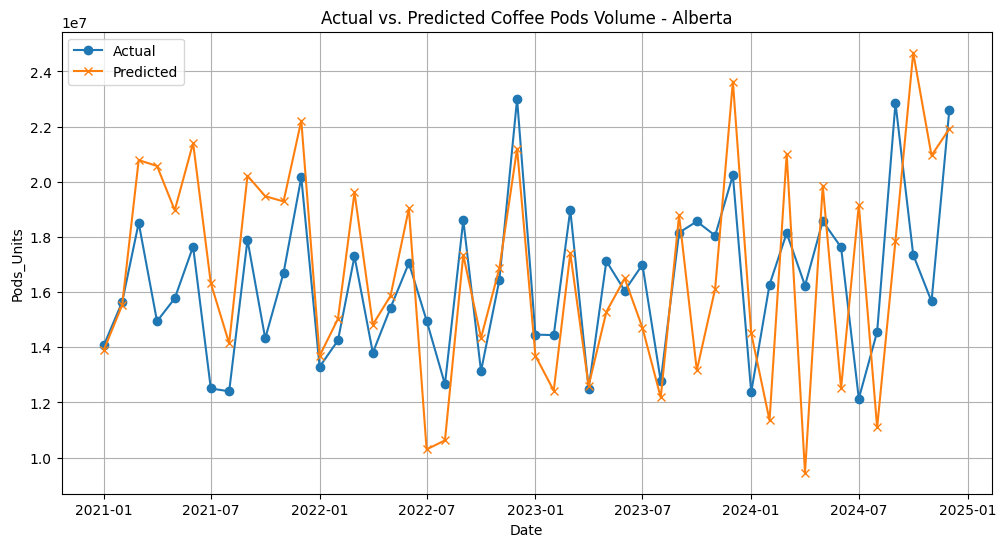

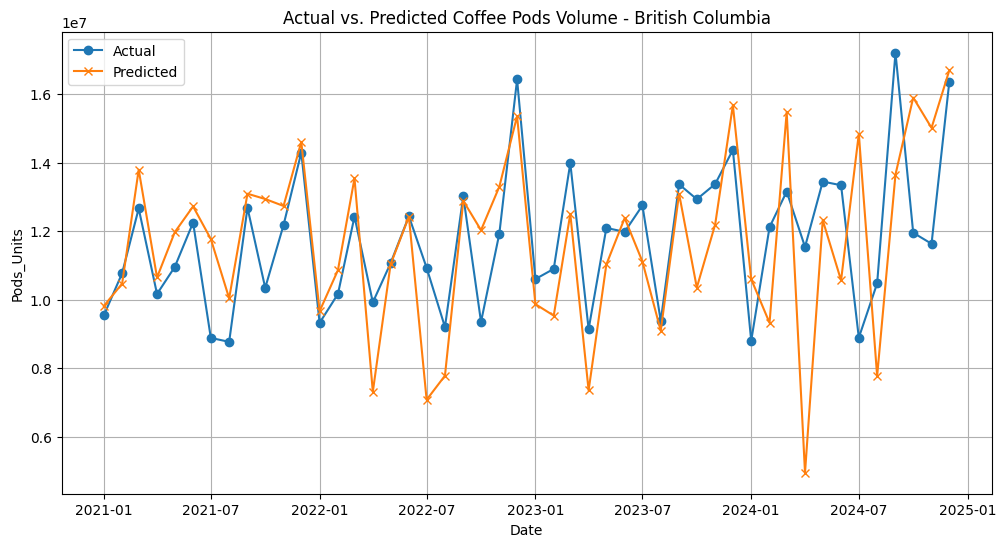

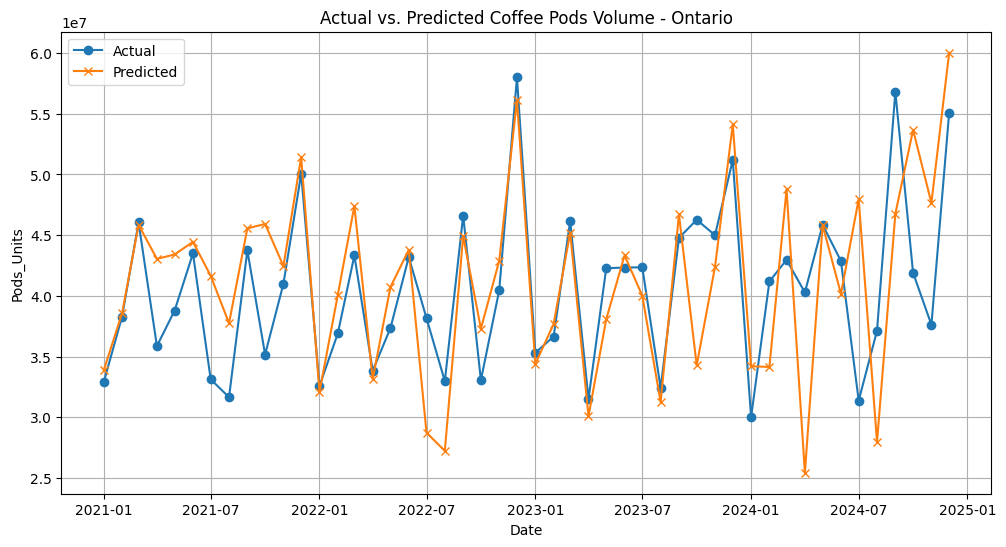

In [ ]:
import matplotlib.pyplot as plt

def plot_final_results(final_results):
    """
    Plots actual vs. predicted values for each region in the final_results DataFrame.

    Args:
        final_results (pd.DataFrame): DataFrame containing 'Region', 'Timestamp_Index',
                                        'Actual', and 'Prediction' columns.
    """
    regions = final_results['Region'].unique()

    for region in regions:
        region_data = final_results[final_results['Region'] == region]

        plt.figure(figsize=(12, 6))
        plt.plot(region_data['Date'], region_data['Actual'], label='Actual', marker='o')
        plt.plot(region_data['Date'], region_data['Prediction'], label='Predicted', marker='x')

        plt.title(f'Actual vs. Predicted Coffee Pods Volume - {region}')
        plt.xlabel('Date')
        plt.ylabel('Pods_Units')
        plt.legend()
        plt.grid(True)
        plt.show()


plot_final_results(final_results)

Best Parameters: {'n_estimators': 10, 'max_depth': 2, 'learning_rate': 0.05, 'subsample': 1.0}


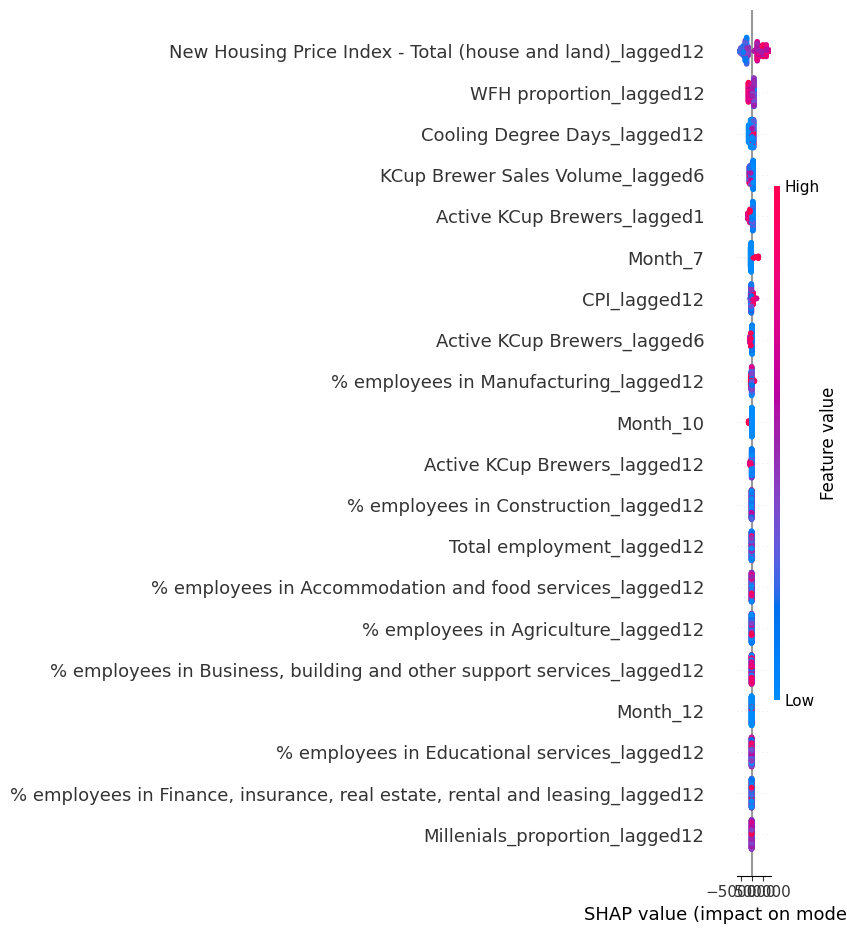


Adjusted Forecast Evaluation
MAPE: 24.56%
RMSE: 32584049.44
R2 Score: -0.935

Prediction Evaluation
MAPE: 24.43%
RMSE: 32261033.14
R2 Score: -0.897


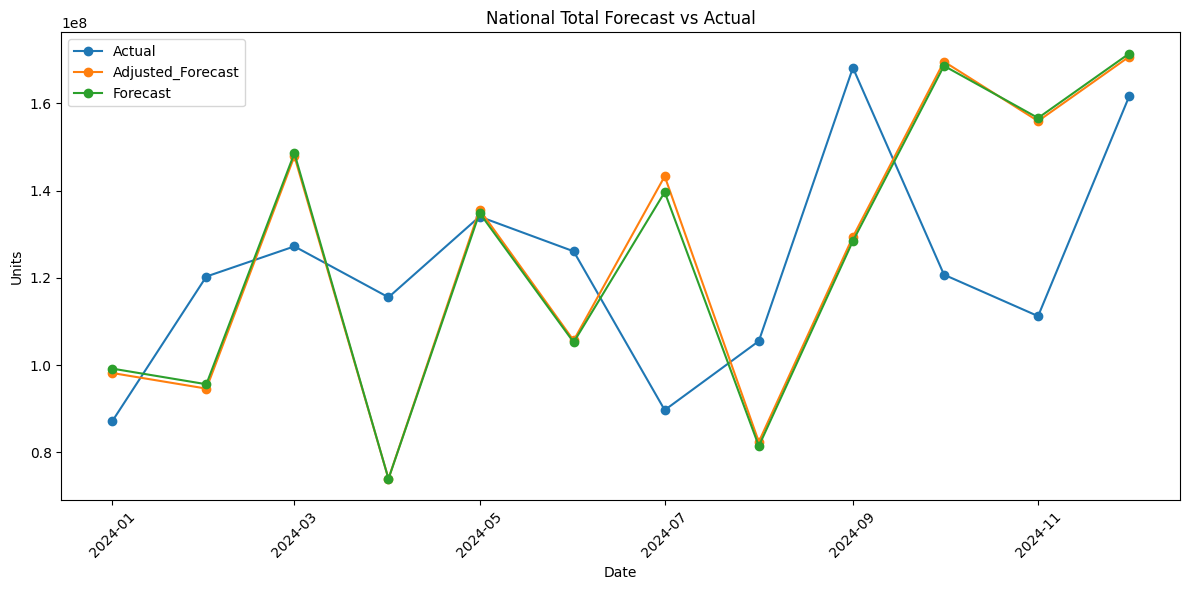

Number of feature names: 74
Number of importances: 74
Number of filtered feature names: 11
Number of filtered importances: 11


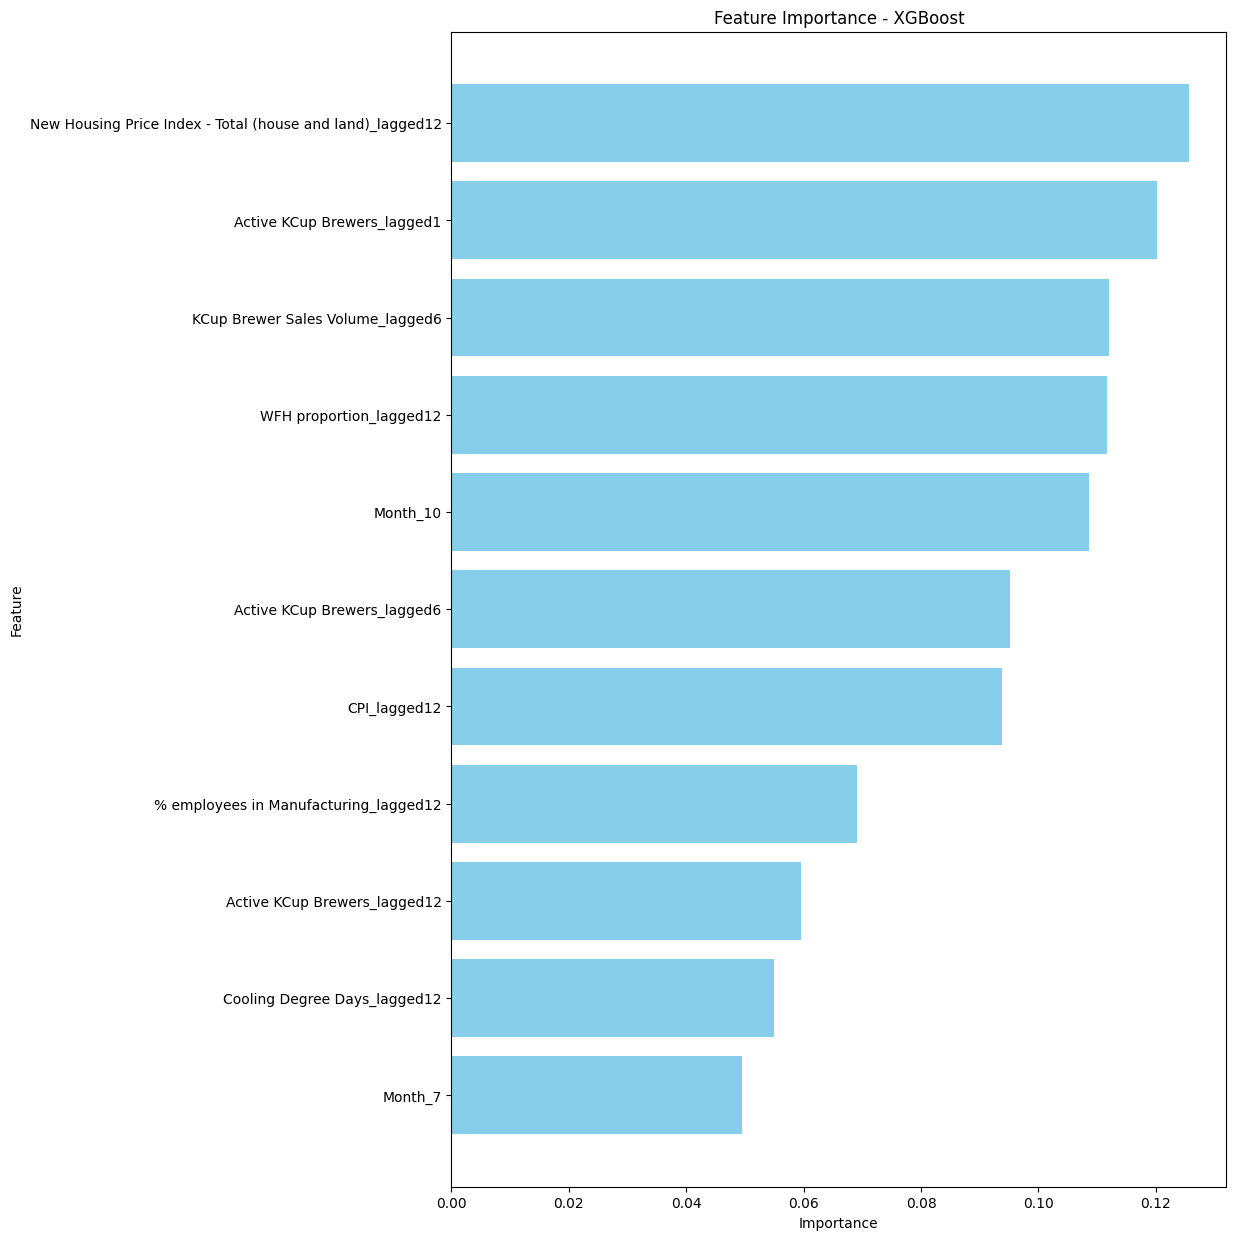

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
#! pip install shap
import shap
import matplotlib.pyplot as plt

def predict_residuals(residuals, external_data):
    """Use external features to predict the residuals using XGBoost"""

    # Merge residuals and the external data
    combined_data = residuals.merge(external_data, on=['Date', 'Region'], how='left')
    combined_copy = combined_data.copy()
    combined_copy['Month'] = combined_copy['Date'].dt.month

    # Dummify region and month
    combined_copy = pd.get_dummies(combined_copy, columns=['Region', 'Month'])

    unique_dates = sorted(combined_copy['Date'].unique())

    # Split data into train test (last 12 dates as test)
    train_data = combined_copy[~combined_copy['Date'].isin(unique_dates[-12:])]
    test_data = combined_copy[combined_copy['Date'].isin(unique_dates[-12:])]

    # Set up variables
    features = [col for col in combined_copy.columns if col not in ['Date', 'Actual', 'Prediction', 'Residual']]
    y_train, y_test = train_data['Residual'], test_data['Residual']
    X_train, X_test = train_data[features], test_data[features]

    # Define parameter for tuning
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [2, 3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }

    # Function to perform cross-validation manually
    def cross_val(X, y, params):
        kf = KFold(n_splits=5, shuffle=True, random_state=42)
        scores = []

        for train_index, val_index in kf.split(X):
            X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

            model = xgb.XGBRegressor(eval_metric='mape', **params, random_state=42)
            model.fit(X_train_fold, y_train_fold)

            y_pred = model.predict(X_val_fold)
            score = mean_absolute_percentage_error(y_val_fold, y_pred)
            scores.append(score)

        return np.mean(scores)

    # Manually tune hyperparameters
    best_score = float('inf')
    best_params = None

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                for subsample in param_grid['subsample']:
                    params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'subsample': subsample
                    }

                    score = cross_val(X_train, y_train, params)

                    if score < best_score:
                        best_score = score
                        best_params = params

    print(f"Best Parameters: {best_params}")

    X_train_encoded = X_train.copy()
    X_bool = X_train_encoded.select_dtypes(include=['boolean'])
    X_train_encoded[X_bool.columns] = X_bool.astype(float)

    # Train best model on X_train
    best_xgb = xgb.XGBRegressor(**best_params, eval_metric='mape', random_state=42)
    best_xgb.fit(X_train, y_train)

    # Store feature importance
    importances = best_xgb.feature_importances_

    # Plot SHAP
    explainer = shap.Explainer(best_xgb, X_train_encoded)
    shap_values = explainer(X_train_encoded)
    shap.summary_plot(shap_values, X_train_encoded)

    # Predict residuals
    residual_predictions = best_xgb.predict(X_test)

    # Create residuals_pred DataFrame
    residuals_pred = combined_data[combined_data['Date'].isin(unique_dates[-12:])].copy()
    residuals_pred['Predicted_Residual'] = residual_predictions
    residuals_pred['Adjusted_Forecast'] = residuals_pred['Prediction'] + residuals_pred['Predicted_Residual']

    return residuals_pred, importances, features  # Return importances

def evaluate_predictions(y_true, y_pred, title="Model Evaluation"):
    """Evaluate prediction results"""
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n{title}")
    print(f"MAPE: {mape:.2%}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.3f}")

    return {'mape': mape, 'rmse': rmse, 'r2': r2}

def plot_forecast_vs_actual(forecasts, title=None):
    """Visualize forecast results vs actual values (aggregated across regions)"""

    # Aggregate data by date
    aggregated_data = forecasts.groupby('Date').agg({
        'Actual': 'sum',
        'Prediction': 'sum',
        'Adjusted_Forecast': 'sum'
    }).reset_index()

    title = title or "National Total Forecast vs Actual"

    plt.figure(figsize=(12, 6))
    plt.plot(aggregated_data['Date'], aggregated_data['Actual'], label='Actual', marker='o')
    plt.plot(aggregated_data['Date'], aggregated_data['Adjusted_Forecast'], label='Adjusted_Forecast', marker='o')
    plt.plot(aggregated_data['Date'], aggregated_data['Prediction'], label='Forecast', marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Units')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_importances(importances, feature_names):
    print(f"Number of feature names: {len(feature_names)}")
    print(f"Number of importances: {len(importances)}")

    # Check if lengths match before proceeding
    if len(feature_names) != len(importances):
        print("Error: Feature names and importances have different lengths.")
        return  # Exit the function

    # Use indices for filtering
    nonzero_indices = np.nonzero(importances)[0]

    # Check if indices are within range
    valid_indices = [i for i in nonzero_indices if i < len(feature_names)]

    filtered_feature_names = [feature_names[i] for i in valid_indices]
    filtered_importances = importances[valid_indices]

    print(f"Number of filtered feature names: {len(filtered_feature_names)}")
    print(f"Number of filtered importances: {len(filtered_importances)}")

    # Explicit length check
    if len(filtered_feature_names) != len(filtered_importances):
        print("Error: Filtered feature names and importances have different lengths.")
        return  # Exit the function

    feature_importance_df = pd.DataFrame({
        'Feature': filtered_feature_names,
        'Importance': filtered_importances
    })
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 15))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance - XGBoost')
    plt.gca().invert_yaxis()
    plt.show()

# Load data
external_data = pd.read_csv('/content/used_external_features.csv')
external_data['Date'] = pd.to_datetime(external_data['Date'])

# Call function
residuals_pred, importances, features = predict_residuals(final_results, external_data)

# Aggregate data for evaluation
aggregated_data = residuals_pred.groupby('Date').agg({
    'Actual': 'sum',
    'Prediction': 'sum',
    'Adjusted_Forecast': 'sum'
}).reset_index()

# Evaluate predictions
evaluation_results = evaluate_predictions(aggregated_data['Actual'], aggregated_data['Adjusted_Forecast'], title="Adjusted Forecast Evaluation")
evaluation_results_prediction = evaluate_predictions(aggregated_data['Actual'], aggregated_data['Prediction'], title = "Prediction Evaluation")

# Plot forecast vs actual (aggregated)
plot_forecast_vs_actual(residuals_pred)

# Plot feature importances
#feature_names = [col for col in residuals_pred.columns if col not in ['Date', 'Actual', 'Prediction', 'Residual', 'Predicted_Residual', 'Adjusted_Forecast']]
plot_importances(importances, features)

In [ ]:
residuals_pred[['Region', 'Actual', 'Prediction', 'Residual', 'Date', 'Predicted_Residual', 'Adjusted_Forecast']]

Region      Actual  Prediction    Residual       Date  \
36   Alberta  12369389.0  14509212.0  -2139823.0 2024-01-01   
37   Alberta  16270918.0  11351072.0   4919846.0 2024-02-01   
38   Alberta  18138614.0  21012822.0  -2874208.0 2024-03-01   
39   Alberta  16236229.0   9451212.0   6785017.0 2024-04-01   
40   Alberta  18572124.0  19860074.0  -1287950.0 2024-05-01   
..       ...         ...         ...         ...        ...   
283   Quebec  26489974.0  21109500.0   5380474.0 2024-08-01   
284   Quebec  44299272.0  31536312.0  12762960.0 2024-09-01   
285   Quebec  30171770.0  46259796.0 -16088026.0 2024-10-01   
286   Quebec  29081094.0  46924688.0 -17843594.0 2024-11-01   
287   Quebec  41337912.0  44839008.0  -3501096.0 2024-12-01   

     Predicted_Residual  Adjusted_Forecast  
36       -381027.500000         14128184.0  
37       -372475.281250         10978597.0  
38       -578887.812500         20433934.0  
39       -372475.281250          9078737.0  
40         14370.386719         19874444.0  
..                  ...                ...  
283       421250.968750         21530750.0  
284       421250.968750         31957562.0  
285       421250.968750         46681048.0  
286        99832.914062         47024520.0  
287        99832.914062         44938840.0  

[72 rows x 7 columns]

## Whole Category modelling

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Configuration
class Configs:
    def __init__(self):
        self.seq_len = 24
        self.pred_len = 12
        self.d_model = 64
        self.nhead = 4
        self.num_encoder_layers = 2
        self.num_decoder_layers = 2
        self.dropout = 0.1
        self.batch_size = 36
        self.lr = 0.001
        self.num_epochs = 500

configs = Configs()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class NonStationaryTransformer(nn.Module):
    def __init__(self, configs):
        super(NonStationaryTransformer, self).__init__()
        self.seq_len = configs.seq_len
        self.pred_len = configs.pred_len
        self.d_model = configs.d_model
        self.nhead = configs.nhead
        self.num_encoder_layers = configs.num_encoder_layers
        self.num_decoder_layers = configs.num_decoder_layers
        self.dropout = configs.dropout

        # Embedding layers
        self.encoder_embedding = nn.Linear(1, self.d_model)
        self.decoder_embedding = nn.Linear(1, self.d_model)

        # Time Embedding
        self.time_embedding = nn.Embedding(configs.seq_len + configs.pred_len, self.d_model)

        # Transformer
        self.transformer = nn.Transformer(
            d_model=self.d_model,
            nhead=self.nhead,
            num_encoder_layers=self.num_encoder_layers,
            num_decoder_layers=self.num_decoder_layers,
            dropout=self.dropout,
            batch_first=True
        )

        # Output layer
        self.fc_out = nn.Linear(self.d_model, 1)

        # Adaptive Normalization
        self.adaptive_norm = nn.LayerNorm(self.d_model)

        # Sophisticated Trend and Seasonal Components
        self.trend_layer = nn.Sequential(
            nn.Linear(self.seq_len, 64),
            nn.ReLU(),
            nn.Linear(64, self.pred_len)
        )
        self.seasonal_layer = nn.Sequential(
            nn.Linear(self.seq_len, 64),
            nn.ReLU(),
            nn.Linear(64, self.pred_len)
        )

    def forward(self, encoder_input, decoder_input):
        encoder_embedded = self.encoder_embedding(encoder_input)
        decoder_embedded = self.decoder_embedding(decoder_input)

        # Create time indices for embedding
        encoder_time_indices = torch.arange(self.seq_len, device=encoder_input.device).unsqueeze(0).repeat(encoder_input.size(0), 1)
        decoder_time_indices = torch.arange(self.seq_len, self.seq_len + self.pred_len, device=decoder_input.device).unsqueeze(0).repeat(decoder_input.size(0), 1)

        # Add time embeddings
        encoder_embedded += self.time_embedding(encoder_time_indices)
        decoder_embedded += self.time_embedding(decoder_time_indices)

        transformer_output = self.transformer(encoder_embedded, decoder_embedded)

        # Adaptive Normalization
        transformer_output = self.adaptive_norm(transformer_output)

        output = self.fc_out(transformer_output)

        # Trend and Seasonal Components
        trend = self.trend_layer(encoder_input.squeeze(-1)).unsqueeze(-1)
        seasonal = self.seasonal_layer(encoder_input.squeeze(-1)).unsqueeze(-1)
        output = output + trend + seasonal

        return output

class RollingWindowDataset(Dataset):
    def __init__(self, df, seq_len, pred_len, region):
        self.df = df[df['Region'] == region].reset_index(drop=True)
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.data_len = len(self.df)
        self.start_offset = (self.data_len - self.pred_len - self.seq_len) % self.pred_len

    def __len__(self):
        if self.data_len >= self.seq_len + self.pred_len + self.start_offset:
            return (self.data_len - self.seq_len - self.pred_len - self.start_offset) // self.pred_len + 1
        else:
            return 0

    def __getitem__(self, idx):
        start_idx = idx * self.pred_len + self.start_offset
        end_idx = start_idx + self.seq_len + self.pred_len

        encoder_input = self.df['Pods_Units'].iloc[start_idx : start_idx + self.seq_len].values
        decoder_input = self.df['Pods_Units'].iloc[start_idx + self.seq_len : end_idx].values
        target = self.df['Pods_Units'].iloc[start_idx + self.seq_len : end_idx].values
        #dates = self.df['Date'].iloc[start_idx + self.seq_len : end_idx].values

        encoder_input = torch.tensor(encoder_input, dtype=torch.float32).unsqueeze(-1)
        decoder_input = torch.tensor(decoder_input, dtype=torch.float32).unsqueeze(-1)
        target = torch.tensor(target, dtype=torch.float32)

        return encoder_input, decoder_input, target
        #return encoder_input, decoder_input, target, dates

def train_test_split(df, configs):
    region_dataloaders = {}
    regions = df['Region'].unique()

    for region in regions:
        region_df = df[df['Region'] == region].reset_index(drop=True)
        data_len = len(region_df)

        # Last 12 months for testing
        test_len = configs.pred_len
        train_len = data_len - test_len

        # Create training dataset
        train_dataset = RollingWindowDataset(region_df.iloc[:train_len], configs.seq_len, configs.pred_len, region)
        train_loader = DataLoader(train_dataset, batch_size=configs.batch_size, shuffle=False)

        # Create test dataset
        test_data = region_df.iloc[train_len - configs.seq_len:] # to include seq_len months before test set
        test_encoder_input = test_data['Pods_Units'].iloc[:configs.seq_len].values # last seq months of training data
        test_decoder_input = test_data['Pods_Units'].iloc[configs.seq_len:].values # test set data
        test_target = test_data['Pods_Units'].iloc[configs.seq_len:].values # test set data
        #test_dates = test_data['Date'].iloc[configs.seq_len:].values

        # Convert test data to tensors
        test_encoder_input = torch.tensor(test_encoder_input, dtype=torch.float32).unsqueeze(-1)
        test_decoder_input = torch.tensor(test_decoder_input, dtype=torch.float32).unsqueeze(-1)
        test_target = torch.tensor(test_target, dtype=torch.float32)

        # Create test dataset
        test_batch = [(test_encoder_input, test_decoder_input, test_target)]
        #test_dataset = torch.utils.data.TensorDataset(test_encoder_input, test_decoder_input, test_target)
        test_loader = DataLoader(test_batch, batch_size=1, shuffle=False)

        region_dataloaders[region] = {'train': train_loader, 'test': test_loader}

    return region_dataloaders

def train(region_dataloaders, configs):
    region_models = {}

    for region, dataloaders in region_dataloaders.items():
        model = NonStationaryTransformer(configs).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=configs.lr)

        train_loader = dataloaders['train']

        for epoch in range(configs.num_epochs):
            model.train()
            train_loss = 0.0

            for encoder_input, decoder_input, target in train_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                optimizer.zero_grad()
                output = model(encoder_input, decoder_input).squeeze(-1)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            if (epoch + 1) % 100 ==0:
                print(f"Region: {region}, Epoch: {epoch+1}, Loss: {train_loss/len(train_loader)}")

        region_models[region] = model

    return region_models

def evaluate(region_models, region_dataloaders, configs):
    test_results = {}

    for region, model in region_models.items():
        model.eval()
        criterion = nn.MSELoss()
        test_loader = region_dataloaders[region]['test']

        total_loss = 0.0

        with torch.no_grad():
            for encoder_input, decoder_input, target in test_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                output = model(encoder_input, decoder_input).squeeze(-1)
                loss = criterion(output, target)
                total_loss += loss.item()

        #print(len(test_loader))
        test_results[region] = total_loss

    return test_results

def predict_combine(region_models, df, configs):
    '''
    Generate predictions for each rolling window using the trained models, calculate residuals,
    and combine into a single DataFrame. Also calculate overall MAPE and final prediction MAPE.
    '''
    combined_results = []
    overall_actuals = []
    overall_predictions = []
    final_pred_actuals = []
    final_pred_predictions = []

    for region, model in region_models.items():
        model.eval()
        region_df = df[df['Region'] == region].copy().reset_index(drop=True)

        predictions = []
        actuals = []
        time_indices = []
        #dates = []

        # Create dataset for the region
        region_dataset = RollingWindowDataset(
            df=region_df,
            seq_len=configs.seq_len,
            pred_len=configs.pred_len,
            region=region
        )
        region_loader = DataLoader(region_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for idx, (encoder_input, decoder_input, target) in enumerate(region_loader):
            #for encoder_input, decoder_input, target in region_loader:
                encoder_input = encoder_input.to(device)
                decoder_input = decoder_input.to(device)
                target = target.to(device)

                # Forward pass
                output = model(encoder_input, decoder_input).squeeze(-1)

                # Store predictions, actual values, and time indices
                predictions.extend(output.cpu().numpy().flatten())
                actuals.extend(target.cpu().numpy().flatten())
                #dates.extend(window_dates)

                # Calculate time indices
                start_idx = region_dataset.start_offset + idx * configs.pred_len
                window_indices = region_df.index[start_idx + configs.seq_len : start_idx + configs.pred_len + configs.seq_len]
                time_indices.extend(window_indices.tolist())  # Use start indices for time indices

        # Calculate residuals
        predictions = np.array(predictions)
        actuals = np.array(actuals)
        residuals = actuals - predictions

        # Store overall actuals and predictions for overall MAPE
        overall_actuals.extend(actuals)
        overall_predictions.extend(predictions)

        # Store final prediction actuals and predictions
        final_pred_actuals.append(actuals[-configs.pred_len:])
        final_pred_predictions.append(predictions[-configs.pred_len:])

        # Create DataFrame for region results
        region_results = pd.DataFrame({
            'Region': region,
            'Timestamp_Index': time_indices,
            #'Date': dates,
            'Actual': actuals,
            'Prediction': predictions,
            'Residual': residuals
        })

        # Append region results to combined results
        combined_results.append(region_results)

    # Combine all results into a single DataFrame
    final_results = pd.concat(combined_results, ignore_index=True)

    # Merge with original df to get corresponding dates
    final_results = final_results.merge(df[['Date']].reset_index(), left_on=['Timestamp_Index'], right_on='index', how='left').drop(columns=['index', 'Timestamp_Index'])

    # Overall MAPE across all regions
    overall_mape = np.mean(np.abs((np.array(overall_actuals) - np.array(overall_predictions)) / np.array(overall_actuals))) * 100

    # Final prediction MAPE (for the final round of predictions)
    final_pred_mape = np.mean(np.abs((np.array(final_pred_actuals) - np.array(final_pred_predictions)) / np.array(final_pred_actuals))) * 100

    return final_results, overall_mape, final_pred_mape

# Pre-processing
df_full = pd.read_excel("/content/PODs_Volume.xlsx")

# Preprocess data
df_full['Date'] = pd.to_datetime(df_full['Date'])
df_full = df_full[df_full['Region'] != 'West']
df_full = df_full.groupby(['Region', 'Date'], as_index=False)['Pods_Units'].sum()

# Sort data by Region and Date
df_full = df_full.sort_values(by=['Region', 'Date']).reset_index(drop=True)
df_full['Timestamp_Index'] = (df_full['Date'].dt.year - 2019) * 12 + (df_full['Date'].dt.month - 1)

# Create dataloaders for rolling window
region_dataloader = train_test_split(df_full, configs)  # Use the correct function name

# Train models for each region
region_models = train(region_dataloader, configs)

# Test models and get test results
test_results = evaluate(region_models, region_dataloader, configs)  # Use the correct function name

# Generate predictions and calculate MAPE
final_results, overall_mape, final_pred_mape = predict_combine(region_models, df_full, configs)

print("Overall MAPE:", overall_mape)
print("Final Prediction MAPE:", final_pred_mape)

final_results.head(10)

Region: Alberta, Epoch: 100, Loss: 1843559661568.0
Region: Alberta, Epoch: 200, Loss: 1636168105984.0
Region: Alberta, Epoch: 300, Loss: 1423679422464.0
Region: Alberta, Epoch: 400, Loss: 1220627922944.0
Region: Alberta, Epoch: 500, Loss: 1035525292032.0
Region: Atlantic, Epoch: 100, Loss: 520846213120.0
Region: Atlantic, Epoch: 200, Loss: 488179761152.0
Region: Atlantic, Epoch: 300, Loss: 451088744448.0
Region: Atlantic, Epoch: 400, Loss: 410905214976.0
Region: Atlantic, Epoch: 500, Loss: 369455267840.0
Region: British Columbia, Epoch: 100, Loss: 1084488941568.0
Region: British Columbia, Epoch: 200, Loss: 909472169984.0
Region: British Columbia, Epoch: 300, Loss: 764412493824.0
Region: British Columbia, Epoch: 400, Loss: 638459707392.0
Region: British Columbia, Epoch: 500, Loss: 521580937216.0
Region: Manitoba/Saskatchewan, Epoch: 100, Loss: 495091744768.0
Region: Manitoba/Saskatchewan, Epoch: 200, Loss: 450778824704.0
Region: Manitoba/Saskatchewan, Epoch: 300, Loss: 400962420736.0
Re

Region      Actual  Prediction   Residual       Date
0  Alberta  18005062.0  17272220.0   732842.0 2021-01-01
1  Alberta  19684178.0  18588106.0  1096072.0 2021-02-01
2  Alberta  23319184.0  23027016.0   292168.0 2021-03-01
3  Alberta  18987038.0  17519014.0  1468024.0 2021-04-01
4  Alberta  20213980.0  19925852.0   288128.0 2021-05-01
5  Alberta  21927840.0  21129068.0   798772.0 2021-06-01
6  Alberta  15734546.0  16734542.0  -999996.0 2021-07-01
7  Alberta  15819571.0  15738404.0    81167.0 2021-08-01
8  Alberta  22812790.0  21960676.0   852114.0 2021-09-01
9  Alberta  19197028.0  18948138.0   248890.0 2021-10-01

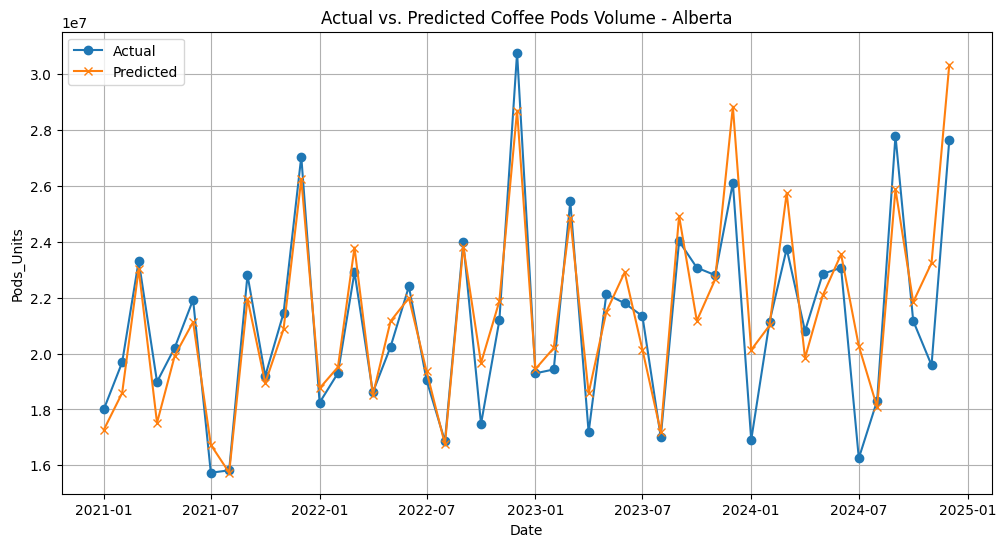

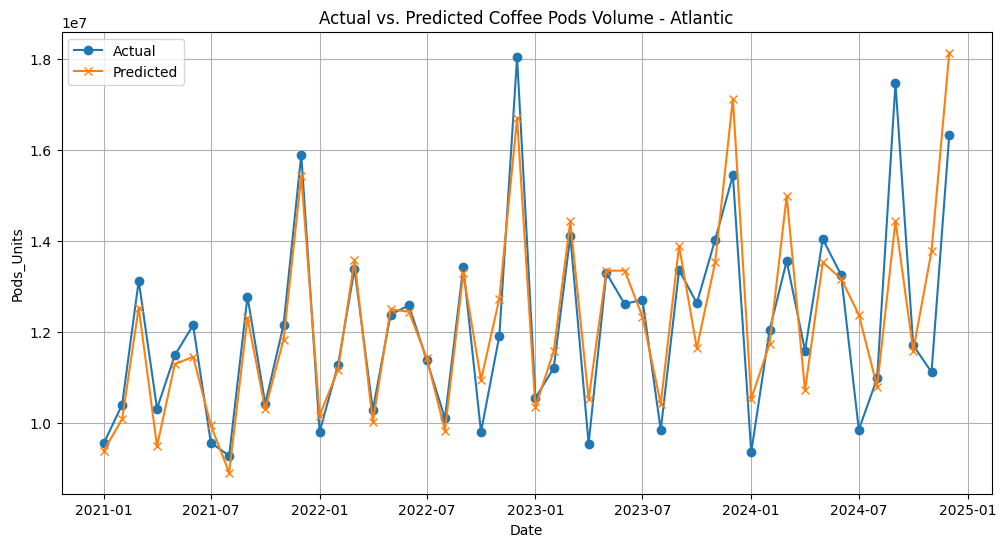

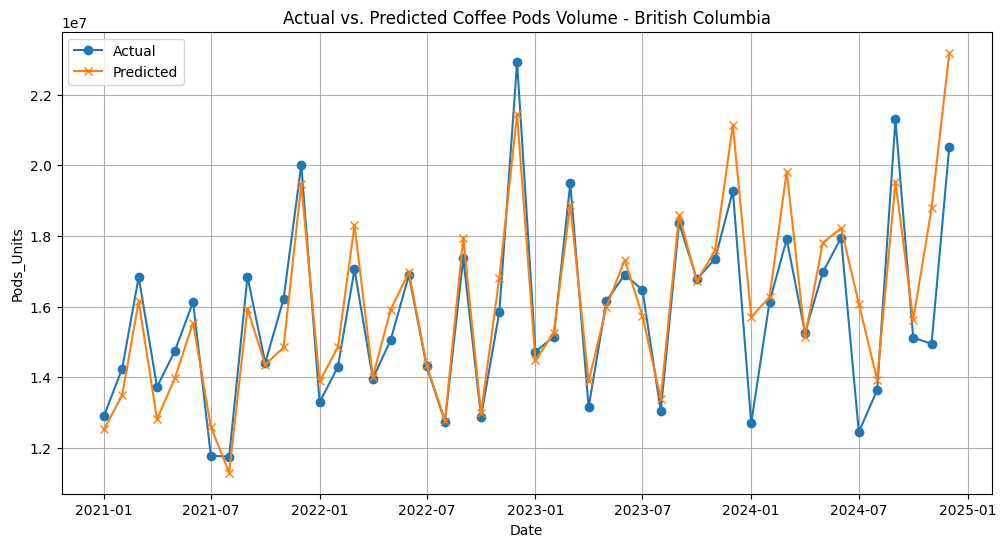

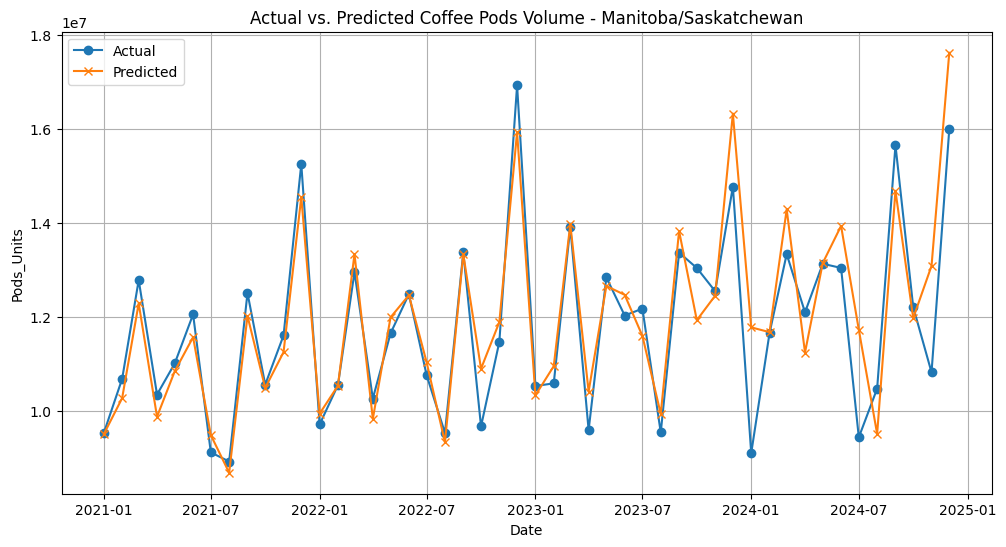

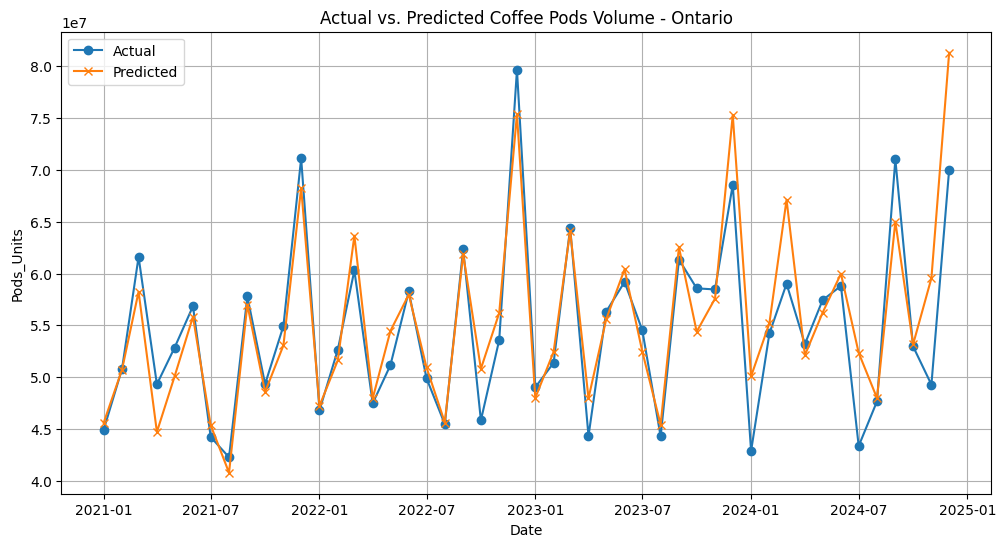

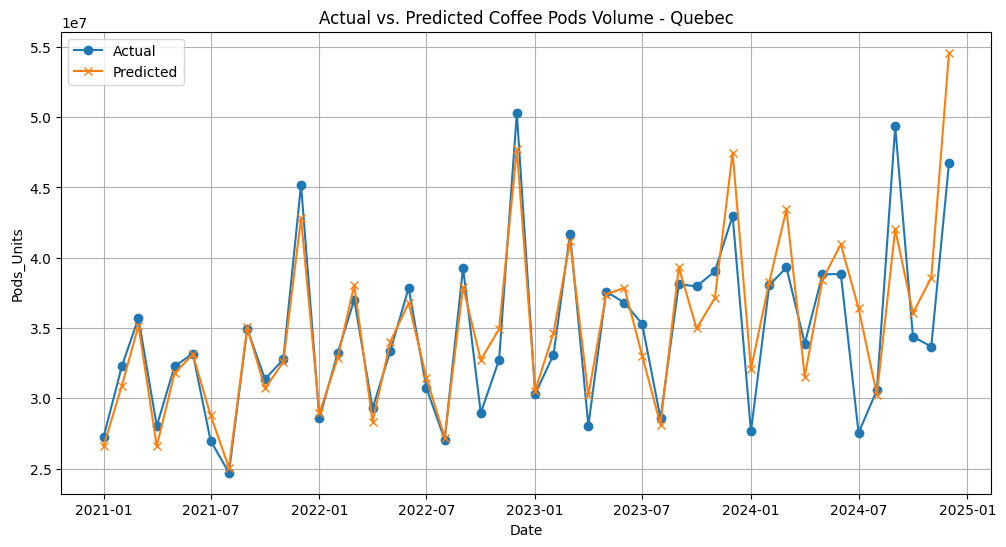

In [23]:
import matplotlib.pyplot as plt

def plot_final_results(final_results):
    """
    Plots actual vs. predicted values for each region in the final_results DataFrame.

    Args:
        final_results (pd.DataFrame): DataFrame containing 'Region', 'Timestamp_Index',
                                        'Actual', and 'Prediction' columns.
    """
    regions = final_results['Region'].unique()

    for region in regions:
        region_data = final_results[final_results['Region'] == region]

        plt.figure(figsize=(12, 6))
        plt.plot(region_data['Date'], region_data['Actual'], label='Actual', marker='o')
        plt.plot(region_data['Date'], region_data['Prediction'], label='Predicted', marker='x')

        plt.title(f'Actual vs. Predicted Coffee Pods Volume - {region}')
        plt.xlabel('Date')
        plt.ylabel('Pods_Units')
        plt.legend()
        plt.grid(True)
        plt.show()


plot_final_results(final_results)

Best Parameters: {'n_estimators': 10, 'max_depth': 2, 'learning_rate': 0.05, 'subsample': 0.8}


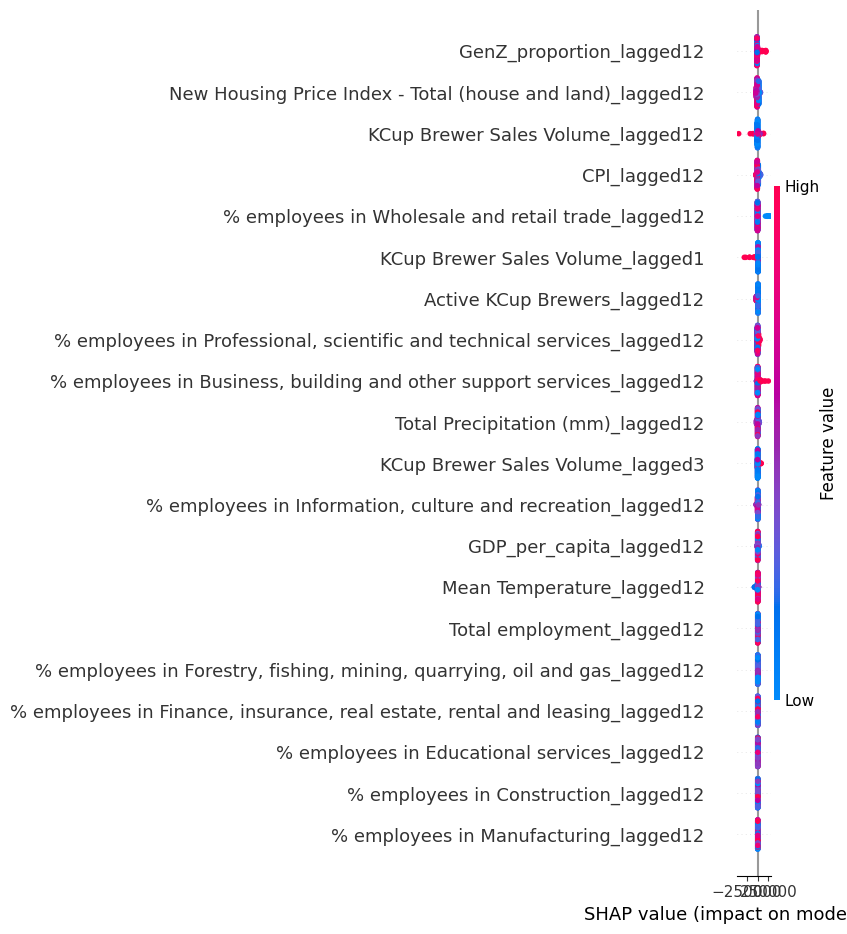


Adjusted Forecast Evaluation
MAPE: 9.33%
RMSE: 17965772.27
R2 Score: 0.509

Prediction Evaluation
MAPE: 9.24%
RMSE: 17768201.56
R2 Score: 0.520


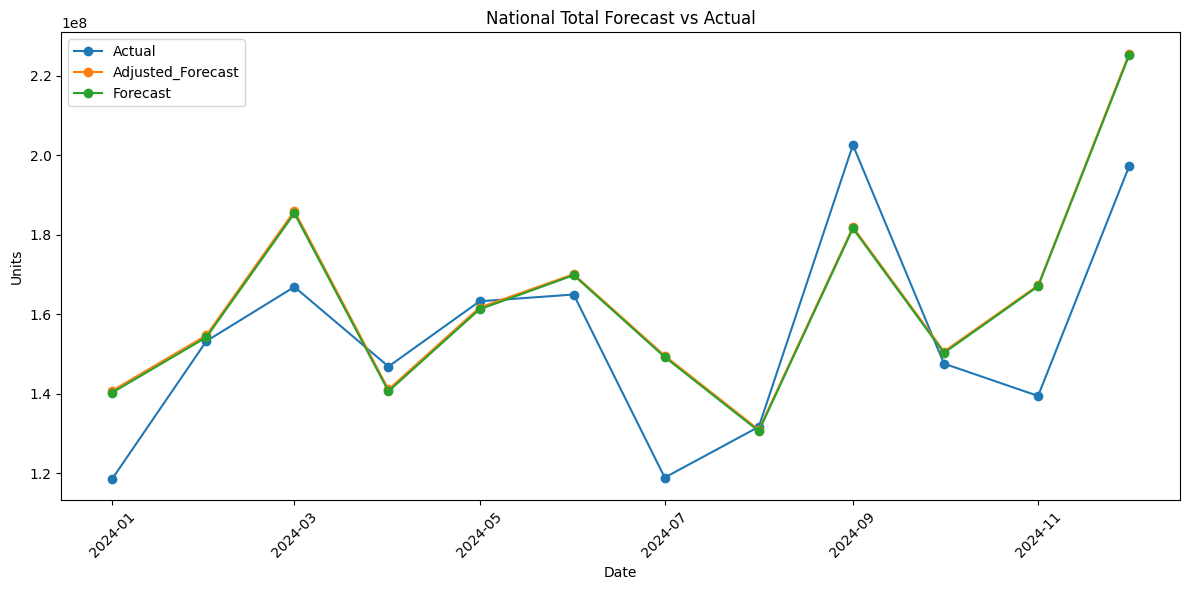

Original feature names count: 74
Original importances count: 74
Adjusted feature names count: 74
Adjusted importances count: 74
Filtered feature names count: 14
Filtered importances count: 14


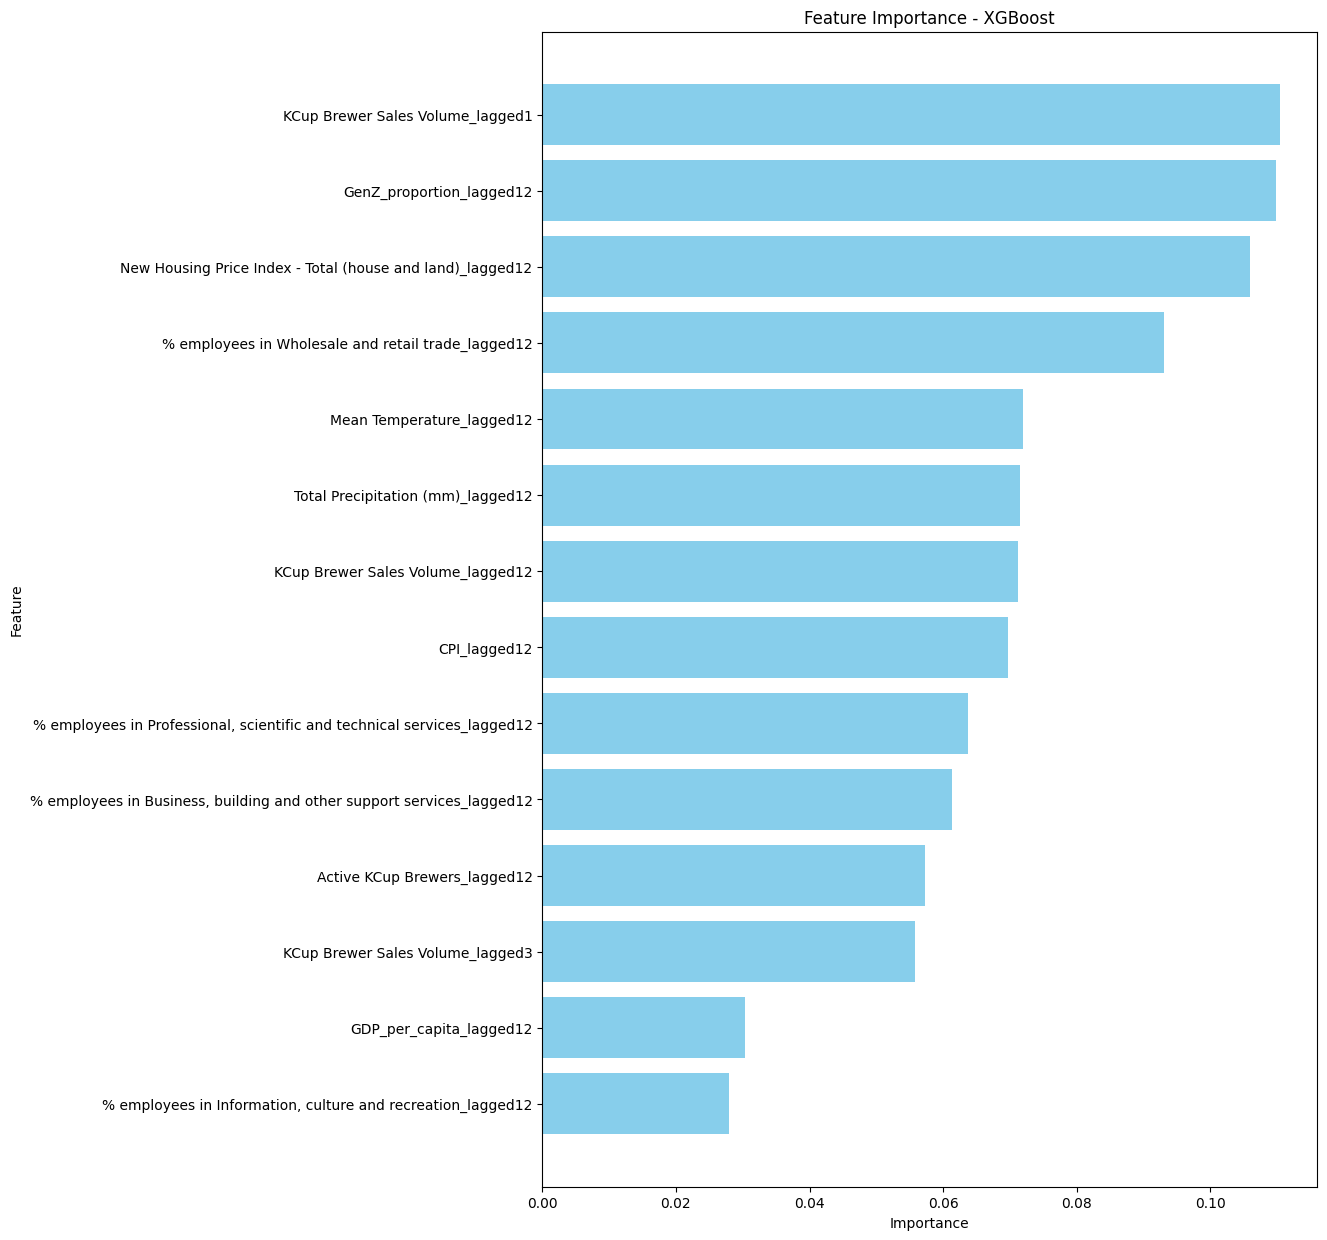

In [24]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
#! pip install shap
import shap
import matplotlib.pyplot as plt

def predict_residuals(residuals, external_data):
    """Use external features to predict the residuals using XGBoost"""

    # Merge residuals and the external data
    combined_data = residuals.merge(external_data, on=['Date', 'Region'], how='left')
    combined_copy = combined_data.copy()
    combined_copy['Month'] = combined_copy['Date'].dt.month

    # Dummify region and month
    combined_copy = pd.get_dummies(combined_copy, columns=['Region', 'Month'])

    unique_dates = sorted(combined_copy['Date'].unique())

    # Split data into train test (last 12 dates as test)
    train_data = combined_copy[~combined_copy['Date'].isin(unique_dates[-12:])]
    test_data = combined_copy[combined_copy['Date'].isin(unique_dates[-12:])]

    # Set up variables
    features = [col for col in combined_copy.columns if col not in ['Date', 'Actual', 'Prediction', 'Residual']]
    y_train, y_test = train_data['Residual'], test_data['Residual']
    X_train, X_test = train_data[features], test_data[features]

    # Define parameter for tuning
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [2, 3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8, 1.0]
    }

    # Function to perform cross-validation manually
    def cross_val(X, y, params):
        kf = KFold(n_splits=5, shuffle=False)
        scores = []

        for train_index, val_index in kf.split(X):
            X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
            y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

            model = xgb.XGBRegressor(eval_metric='mape', **params, random_state=42)
            model.fit(X_train_fold, y_train_fold)

            y_pred = model.predict(X_val_fold)
            score = mean_absolute_percentage_error(y_val_fold, y_pred)
            scores.append(score)

        return np.mean(scores)

    # Manually tune hyperparameters
    best_score = float('inf')
    best_params = None

    for n_estimators in param_grid['n_estimators']:
        for max_depth in param_grid['max_depth']:
            for learning_rate in param_grid['learning_rate']:
                for subsample in param_grid['subsample']:
                    params = {
                        'n_estimators': n_estimators,
                        'max_depth': max_depth,
                        'learning_rate': learning_rate,
                        'subsample': subsample
                    }

                    score = cross_val(X_train, y_train, params)

                    if score < best_score:
                        best_score = score
                        best_params = params

    print(f"Best Parameters: {best_params}")

    X_train_encoded = X_train.copy()
    X_bool = X_train_encoded.select_dtypes(include=['boolean'])
    X_train_encoded[X_bool.columns] = X_bool.astype(float)

    # Train best model on X_train
    best_xgb = xgb.XGBRegressor(**best_params, eval_metric='mape', random_state=42)
    best_xgb.fit(X_train, y_train)

    # Store feature importance
    importances = best_xgb.feature_importances_

    # Plot SHAP
    explainer = shap.Explainer(best_xgb, X_train_encoded)
    shap_values = explainer(X_train_encoded)
    shap.summary_plot(shap_values, X_train_encoded)

    # Predict residuals
    residual_predictions = best_xgb.predict(X_test)

    # Create residuals_pred DataFrame
    residuals_pred = combined_data[combined_data['Date'].isin(unique_dates[-12:])].copy()
    residuals_pred['Predicted_Residual'] = residual_predictions
    residuals_pred['Adjusted_Forecast'] = residuals_pred['Prediction'] + residuals_pred['Predicted_Residual']

    return residuals_pred, importances, features  # Return importances

def evaluate_predictions(y_true, y_pred, title="Model Evaluation"):
    """Evaluate prediction results"""
    mape = mean_absolute_percentage_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"\n{title}")
    print(f"MAPE: {mape:.2%}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R2 Score: {r2:.3f}")

    return {'mape': mape, 'rmse': rmse, 'r2': r2}

def plot_forecast_vs_actual(forecasts, title=None):
    """Visualize forecast results vs actual values (aggregated across regions)"""

    # Aggregate data by date
    aggregated_data = forecasts.groupby('Date').agg({
        'Actual': 'sum',
        'Prediction': 'sum',
        'Adjusted_Forecast': 'sum'
    }).reset_index()

    title = title or "National Total Forecast vs Actual"

    plt.figure(figsize=(12, 6))
    plt.plot(aggregated_data['Date'], aggregated_data['Actual'], label='Actual', marker='o')
    plt.plot(aggregated_data['Date'], aggregated_data['Adjusted_Forecast'], label='Adjusted_Forecast', marker='o')
    plt.plot(aggregated_data['Date'], aggregated_data['Prediction'], label='Forecast', marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Units')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_importances(importances, feature_names):
    print(f"Original feature names count: {len(feature_names)}")
    print(f"Original importances count: {len(importances)}")

    # Ensure importances and feature_names have the same length
    min_length = min(len(importances), len(feature_names))
    importances = importances[:min_length]
    feature_names = feature_names[:min_length]

    print(f"Adjusted feature names count: {len(feature_names)}")
    print(f"Adjusted importances count: {len(importances)}")

    # Use indices for filtering
    nonzero_indices = np.nonzero(importances)[0]
    filtered_feature_names = [feature_names[i] for i in nonzero_indices]
    filtered_importances = importances[nonzero_indices]

    print(f"Filtered feature names count: {len(filtered_feature_names)}")
    print(f"Filtered importances count: {len(filtered_importances)}")

    if len(filtered_feature_names) != len(filtered_importances):
        print("Error: Mismatch in feature names and importance values after filtering.")
        return

    feature_importance_df = pd.DataFrame({
        'Feature': filtered_feature_names,
        'Importance': filtered_importances
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 15))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance - XGBoost')
    plt.gca().invert_yaxis()
    plt.show()

# Load data
external_data = pd.read_csv('/content/used_external_features.csv')
external_data['Date'] = pd.to_datetime(external_data['Date'])

# Call function
residuals_pred, importances, features = predict_residuals(final_results, external_data)

# Aggregate data for evaluation
aggregated_data = residuals_pred.groupby('Date').agg({
    'Actual': 'sum',
    'Prediction': 'sum',
    'Adjusted_Forecast': 'sum'
}).reset_index()

# Evaluate predictions
evaluation_results = evaluate_predictions(aggregated_data['Actual'], aggregated_data['Adjusted_Forecast'], title="Adjusted Forecast Evaluation")
evaluation_results_prediction = evaluate_predictions(aggregated_data['Actual'], aggregated_data['Prediction'], title = "Prediction Evaluation")

# Plot forecast vs actual (aggregated)
plot_forecast_vs_actual(residuals_pred)

# Plot feature importances
#feature_names = [col for col in residuals_pred.columns if col not in ['Date', 'Actual', 'Prediction', 'Residual', 'Predicted_Residual', 'Adjusted_Forecast']]
plot_importances(importances, features)